In [1]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import accuracy_score  
import warnings
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
warnings.filterwarnings("ignore") 

# 1) We stick to the plan -- using random forest model and optimize it

In [42]:
df_btc = pd.read_csv('/Users/yanggongchi/Desktop/my_quant/ml_project_temp/data_with_features/BTC-USDT_5min_data_with_features')
df_eth = pd.read_csv('/Users/yanggongchi/Desktop/my_quant/ml_project_temp/data_with_features/ETH-USDT_5min_data_with_features')
df_btc_cl = df_btc.copy()
df_btc_cl = df_btc_cl.drop(['open', 'high', 'low', 'price_change_pct', 'amount', 'volume','close','next_close'], axis=1)
df_btc_cl.set_index('datetime', inplace=True)
df_btc_cl.drop(df_btc_cl.columns[[0]], axis = 1, inplace = True)
df_eth_cl = df_eth.copy()
df_eth_cl = df_eth_cl.drop(['open', 'high', 'low', 'price_change_pct', 'amount', 'volume','close','next_close'], axis=1)
df_eth_cl.set_index('datetime', inplace=True)
df_eth_cl.drop(df_eth_cl.columns[[0]], axis = 1, inplace = True)

The accuracy score of model is: 0.530551


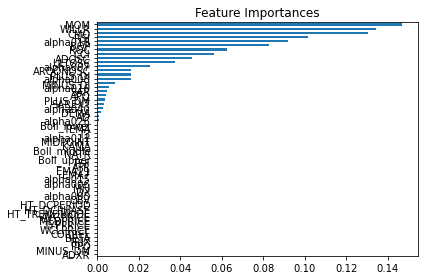

In [43]:
# We use 90% BTC data to predict 10% ETH data to see if the model works well on similar coin
y_train = df_btc_cl['price_direction'].astype('float64').iloc[:int(len(df_btc_cl['price_direction'])*0.9)]
X_train = df_btc_cl.iloc[:, 1:].astype('float64').iloc[:int(len(df_btc_cl['price_direction'])*0.9)]
y_test = df_eth_cl['price_direction'].iloc[int(len(df_eth_cl['price_direction'])*0.9):]
X_test = df_eth_cl.iloc[:, 1:].iloc[int(len(df_eth_cl['price_direction'])*0.9):]
model = RandomForestClassifier(random_state=33)
#find best params
param_distribs = {'n_estimators':range(1,50),'max_depth':range(1,30),'min_samples_leaf':range(1,10)}
random_search = RandomizedSearchCV(model,param_distribs,cv=3,scoring = 'neg_log_loss',n_iter=50,n_jobs = -1)
random_search.fit(X_train,y_train)
model = RandomForestClassifier(n_estimators=random_search.best_params_['n_estimators'],
                               max_depth=random_search.best_params_['max_depth'],
                               min_samples_leaf=random_search.best_params_['min_samples_leaf'],
                               random_state=33)
model.fit(X_train, y_train.astype('int'))
y_pred = model.predict(X_test)
print('The accuracy score of model is: %f' % accuracy_score(y_pred, y_test))
mdi_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=True)
ax = mdi_importances.plot.barh()
ax.set_title("Feature Importances")
ax.figure.tight_layout()
plt.show()

In [44]:
mdi_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
mdi_importances.head(10)

MOM         0.147169
WILLR       0.134608
CMO         0.130704
RSI         0.101709
alpha018    0.092172
BOP         0.082652
ROC         0.062445
CCI         0.056099
ADOSC       0.045658
ULTOSC      0.037393
dtype: float64

In [45]:
random_search.best_params_ # the best parameter find by package

{'n_estimators': 44, 'min_samples_leaf': 4, 'max_depth': 2}

In [46]:
# We then try more steps to see if we can improve the accuracy a little bit(or not XD)
# We use isolated IsolationForest to see if there are some outliners
from sklearn.ensemble import IsolationForest
df_btc_test = df_btc.copy()
df_btc_test.set_index('datetime', inplace=True)
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
model.fit(np.array(df_btc_test['close']).reshape(-1, 1))
df = pd.DataFrame(df_btc_test[['close']],columns=['close'])
df['scores']=model.decision_function(np.array(df_btc_test['close']).reshape(-1, 1))
df['anomaly']=model.predict(np.array(df_btc_test['close']).reshape(-1, 1))
anomaly=df.loc[df['anomaly']==-1]
anomaly_index=list(anomaly.index)

In [47]:
df_btc_cl = df_btc_cl.drop(anomaly_index, axis=0)
# we also delete top 10 bad_performing features
df_btc_cl = df_btc_cl.drop(list(mdi_importances.tail(10).index), axis=1)
X_train = df_btc_cl.iloc[:, 1:].astype('float64').iloc[:int(len(df_btc_cl['price_direction'])*0.9)]
y_train = df_btc_cl['price_direction'].astype('float64').iloc[:int(len(df_btc_cl['price_direction'])*0.9)]
model = RandomForestClassifier(n_estimators=random_search.best_params_['n_estimators'],
                               max_depth=random_search.best_params_['max_depth'],
                               min_samples_leaf=random_search.best_params_['min_samples_leaf'],
                               random_state=33)
model.fit(X_train, y_train.astype('int'))

RandomForestClassifier(max_depth=2, min_samples_leaf=4, n_estimators=44,
                       random_state=33)

In [48]:
df_eth_cl = df_eth_cl.drop(list(mdi_importances.tail(10).index), axis=1)
X_test = df_eth_cl.iloc[int(len(df_eth_cl['price_direction'])*0.9):, 1:]
y_pred = model.predict(X_test)
print('The accuracy score of model is: %f' % accuracy_score(y_pred, y_test))

The accuracy score of model is: 0.532601


In [49]:
'Well... Progress is always good...'

'Well... Progress is always good...'

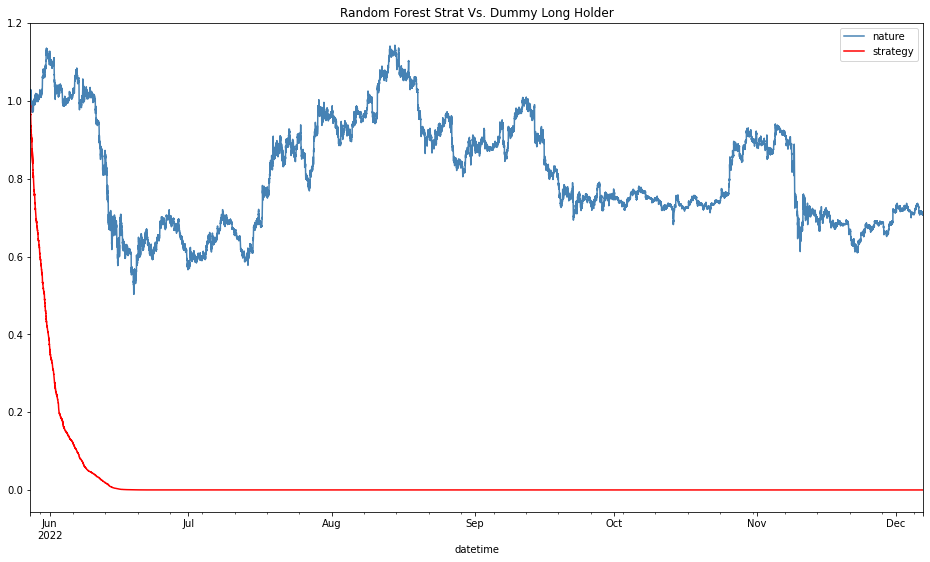

count    55612.000000
mean        -0.000896
std          0.002762
min         -0.080575
25%         -0.001792
50%         -0.000605
75%          0.000367
max          0.032205
Name: strategy_pct, dtype: float64

In [50]:
df_eth_cl = df_eth.copy().iloc[int(len(df_eth_cl['price_direction'])*0.9):, :]
df_eth_cl.set_index('datetime', inplace=True)
df_eth_cl.drop(df_eth_cl.columns[[0]], axis = 1, inplace = True)
df_eth_cl['nature'] = (1.0 + df_eth_cl['price_change_pct']).cumprod()
df_eth_cl['pred'] = y_pred
df_eth_cl['strategy_pct'] = df_eth_cl.apply(lambda x: x.price_change_pct if x.pred>0 else -x.price_change_pct, axis=1)
df_eth_cl['strategy'] = (1.0 + df_eth_cl['strategy_pct']).cumprod()
df_eth_cl.index = pd.to_datetime(df_eth_cl.index)
ax = df_eth_cl[['nature','strategy']].plot(figsize=(16,9), color=['SteelBlue','Red'],
                                          title='Random Forest Strat Vs. Dummy Long Holder')
plt.show()
df_eth_cl['strategy_pct'].describe()

In [51]:
'''
After carefully checking the code to see if there is anything wrong, 
        I decide never to use random forest model to predict time series problems again........
Having said that, maybe there can be a remedy by taking probability into account
'''

'\nAfter carefully checking the code to see if there is anything wrong, \n        I decide never to use random forest model to predict time series problems again........\nHaving said that, maybe there can be a remedy by taking probability into account\n'

In [52]:
df_eth_cl = df_eth.copy()
df_eth_cl=df_eth_cl.iloc[int(len(df_eth_cl['price_direction'])*0.9):, :]
df_eth_cl.set_index('datetime', inplace=True)
df_eth_cl.drop(df_eth_cl.columns[[0]], axis = 1, inplace = True)
df_eth_cl['nature'] = (1.0 + df_eth_cl['price_change_pct']).cumprod()
df_eth_cl['pred'] = y_pred
df_eth_cl['pred_pro'] = [max(x) for x in list(model.predict_proba(X_test))] # take probability into account
df_eth_cl['pred_pro'].describe()

count    55612.000000
mean         0.518279
std          0.013274
min          0.500000
25%          0.507322
50%          0.515114
75%          0.527480
max          0.553067
Name: pred_pro, dtype: float64

In [61]:
'''
Because the model is never more than 60% confident to give prediction,
So maybe only more than 53% that we trade? Maybe it can improve something:
'''

'\nBecause the model is never more than 60% confident to give prediction,\nSo maybe only more than 53% that we trade? Maybe it can improve something:\n'

In [54]:
df_eth_cl['new_pred'] = np.nan
def make_new_trade(df):
    if df.pred_pro >= 0.53:
        df.new_pred = df.pred
    else:
        df.new_pred = 0
    return df
df_eth_cl = df_eth_cl.apply(make_new_trade,axis=1)

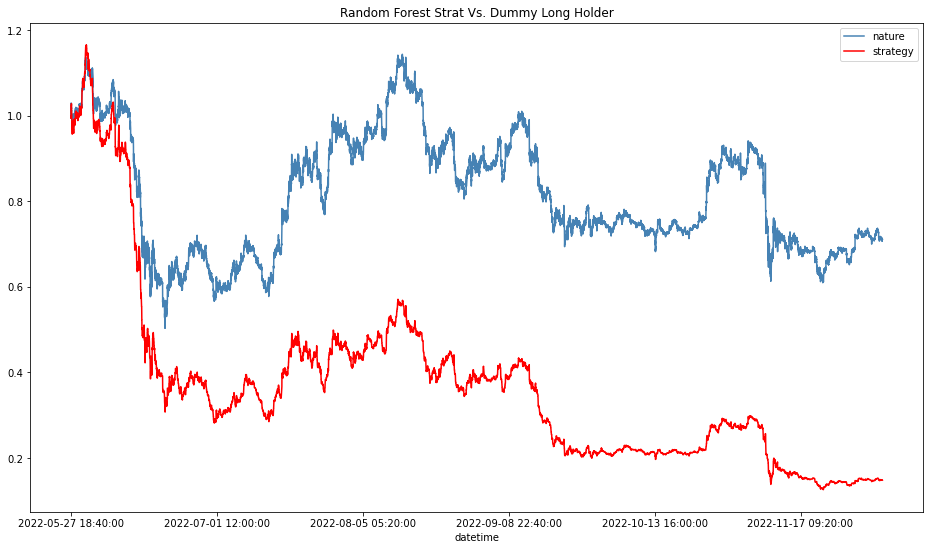

In [55]:
df_eth_cl['new_pct'] = np.nan
def make_new_pct(df):
    if df.new_pred != 0:
        df['new_pct'] = df.price_change_pct
    else:
        df['new_pct'] = 0
    return df
df_eth_cl = df_eth_cl.apply(make_new_pct,axis=1)
df_eth_cl['strategy'] = (1.0 + df_eth_cl['new_pct']).cumprod()
df_eth_cl['nature'] = (1.0 + df_eth_cl['price_change_pct']).cumprod()
ax = df_eth_cl[['nature','strategy']].plot(figsize=(16,9), color=['SteelBlue','Red'],
                                          title='Random Forest Strat Vs. Dummy Long Holder')
plt.show()

In [56]:
df_eth_cl['strategy'].describe()

count    55612.000000
mean         0.369017
std          0.210266
min          0.126172
25%          0.215490
50%          0.348357
75%          0.431898
max          1.165378
Name: strategy, dtype: float64

In [57]:
'''
Even though still not good, but it's happy to see that modification works.
'''

"\nEven though still not good, but it's happy to see that modification works.\n"

In [58]:
'''
To simulate the read world situation, let's add a 0.1% commission fee
'''

"\nTo simulate the read world situation, let's add a 0.1% commission fee\n"

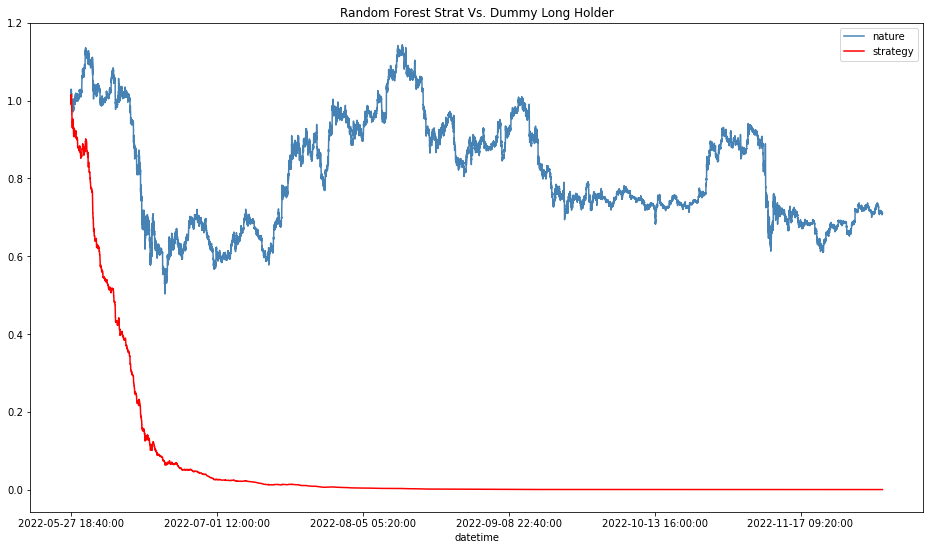

In [59]:
# df_eth_cl = df_eth.copy()
# df_eth_cl.set_index('datetime', inplace=True)
# df_eth_cl.drop(df_eth_cl.columns[[0]], axis = 1, inplace = True)
# df_eth_cl['nature'] = (1.0 + df_eth_cl['price_change_pct']).cumprod()
# df_eth_cl['pred'] = y_pred
# df_eth_cl['pred_pro'] = [max(x) for x in list(model.predict_proba(X_test))] # take probability into account
df_eth_cl['new_pct'] = np.nan
def make_new_pct(df):
    if df.new_pred != 0:
        df['new_pct'] = df.price_change_pct - 0.001
    else:
        df['new_pct'] = 0
    return df
df_eth_cl = df_eth_cl.apply(make_new_pct,axis=1)
df_eth_cl['strategy'] = (1.0 + df_eth_cl['new_pct']).cumprod()
df_eth_cl['nature'] = (1.0 + df_eth_cl['price_change_pct']).cumprod()
ax = df_eth_cl[['nature','strategy']].plot(figsize=(16,9), color=['SteelBlue','Red'],
                                          title='Random Forest Strat Vs. Dummy Long Holder')
plt.show()

In [95]:
'''
After taking commission fee into account, the chart is somehow more like a real-life situation(down_to_zero)
'''

'\nAfter taking commission fee into account, the chart is somehow more like a real-life situation(down_to_zero)\n'

# Plan B: Using AdaBoostingClassifier to see if we can get better result

In [21]:
'''
This is the model chosen by lazypredict. To be honest, after the result of random forest, 
I am not very much optimistic about another classifier, but we'll see
'''

"\nThis is the model chosen by lazypredict. To be honest, after the result of random forest, \nI am not very much optimistic about another classifier, but we'll see\n"

In [29]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

df_btc_cl = df_btc.copy()
df_btc_cl = df_btc_cl.drop(['open', 'high', 'low', 'price_change_pct', 'amount', 'volume','close','next_close'], axis=1)
df_btc_cl.set_index('datetime', inplace=True)
df_btc_cl.drop(df_btc_cl.columns[[0]], axis = 1, inplace = True)
df_eth_cl = df_eth.copy()
df_eth_cl = df_eth_cl.drop(['open', 'high', 'low', 'price_change_pct', 'amount', 'volume','close','next_close'], axis=1)
df_eth_cl.set_index('datetime', inplace=True)
df_eth_cl.drop(df_eth_cl.columns[[0]], axis = 1, inplace = True)
y_train = df_btc_cl['price_direction'].astype('float64')
X_train = df_btc_cl.iloc[:, 1:].astype('float64')
y_test = df_eth_cl['price_direction']
X_test = df_eth_cl.iloc[:, 1:]

In [26]:
Ada=AdaBoostClassifier(n_estimators=40)
Ada.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=40)

In [30]:
X_test = df_eth_cl.iloc[:, 1:]
y_pred = Ada.predict(X_test)
print('The accuracy score of model is: %f' % accuracy_score(y_pred, y_test))

The accuracy score of model is: 0.524075


In [31]:
'''
Now we do what we did for Random Forest Model
Again, this part is just a rough test to see if the lazy_prediction is useful
AdaBoostClassifier is the best classifier recommended by lazy_prediction
'''

'\nNow we do what we did for Random Forest Model\nAgain, this part is just a rough test to see if the lazy_prediction is useful\nAdaBoostClassifier is the best classifier recommended by lazy_prediction\n'

In [32]:
df_eth_cl = df_eth.copy()
df_eth_cl.set_index('datetime', inplace=True)
df_eth_cl.drop(df_eth_cl.columns[[0]], axis = 1, inplace = True)
df_eth_cl['nature'] = (1.0 + df_eth_cl['price_change_pct']).cumprod()
df_eth_cl['pred'] = y_pred
df_eth_cl['pred_pro'] = [max(x) for x in list(Ada.predict_proba(X_test))] # take probability into account
df_eth_cl['pred_pro'].describe()

count    556115.000000
mean          0.500889
std           0.001263
min           0.500000
25%           0.500278
50%           0.500651
75%           0.501193
max           0.521690
Name: pred_pro, dtype: float64

In [35]:
df_eth_cl['new_pred'] = np.nan
def make_new_trade(df):
    if df.pred_pro >= 0.5:
        df.new_pred = df.pred
    else:
        df.new_pred = 0
    return df
df_eth_cl = df_eth_cl.apply(make_new_trade,axis=1)

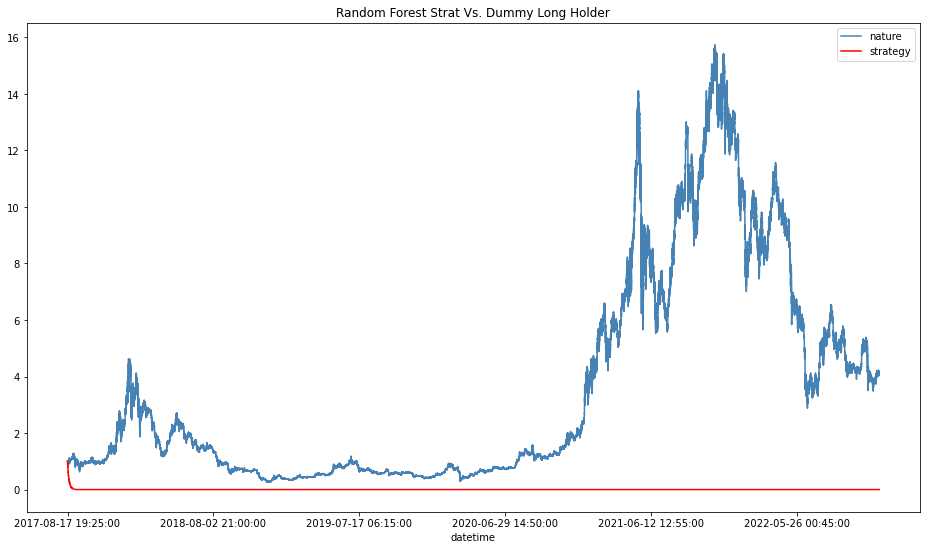

In [36]:
df_eth_cl['new_pct'] = np.nan
def make_new_pct(df):
    if df.new_pred != 0:
        df['new_pct'] = df.price_change_pct - 0.001
    else:
        df['new_pct'] = 0
    return df
df_eth_cl = df_eth_cl.apply(make_new_pct,axis=1)
df_eth_cl['strategy'] = (1.0 + df_eth_cl['new_pct']).cumprod()
df_eth_cl['nature'] = (1.0 + df_eth_cl['price_change_pct']).cumprod()
ax = df_eth_cl[['nature','strategy']].plot(figsize=(16,9), color=['SteelBlue','Red'],
                                          title='Random Forest Strat Vs. Dummy Long Holder')
plt.show()

In [37]:
# Well...Even though this is just a rough test, but it still tells us lazy_predict is just for reference only

# Plan C: Using ARIMA model to do the prediction

In [109]:
from datetime import datetime 
import scipy as stats 
import statsmodels.api as sm 
from scipy import stats 
from statsmodels.tsa.arima_model import ARIMA 

In [110]:
df_btc_re = df_btc.copy()
df_btc_re = df_btc_re.drop(['open', 'high', 'low', 'price_change_pct', 'amount', 'volume', 'price_direction','next_close'], axis=1)
df_btc_re.set_index('datetime', inplace=True)
df_btc_re.drop(df_btc_re.columns[[0]], axis = 1, inplace = True)
df_eth_re = df_eth.copy()
df_eth_re = df_eth_re.drop(['open', 'high', 'low', 'price_change_pct', 'amount', 'volume', 'price_direction','next_close'], axis=1)
df_eth_re.set_index('datetime', inplace=True)
df_eth_re.drop(df_eth_re.columns[[0]], axis = 1, inplace = True)

In [8]:
from statsmodels.tsa.stattools import adfuller
print(u'Original data ADF is：', adfuller(df_btc_re['close'],autolag='AIC')) #Show ADF test result

Original data ADF is： (-1.441303374630302, 0.5623225269860297, 104, 556045, {'1%': -3.430361760433397, '5%': -2.861545197974291, '10%': -2.566772766691638}, 6249618.9973986875)


In [9]:
'''
The null hypothesis of the ADF test is that the time series is non-stationary.
The p-value here is 0.5623225269860297, 
                            which obvious denotes that our price data series is non-stationary
We then use difference to solve this problem
'''

'\nThe null hypothesis of the ADF test is that the time series is non-stationary.\nThe p-value here is 0.5623225269860297, \n                            which obvious denotes that our price data series is non-stationary\nWe then use difference to solve this problem\n'

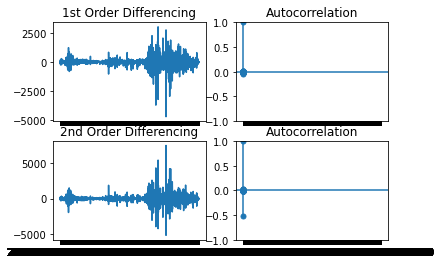

In [9]:
# To see different outcome after difference
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(2, 2, sharex=True)
# 1st Differencing
axes[0, 0].plot(df_btc_re['close'].diff()); axes[0, 0].set_title('1st Order Differencing')
plot_acf(df_btc_re['close'].diff().dropna(), ax=axes[0, 1])

# 2nd Differencing
axes[1, 0].plot(df_btc_re['close'].diff().diff()); axes[1, 0].set_title('2nd Order Differencing')
plot_acf(df_btc_re['close'].diff().diff().dropna(), ax=axes[1, 1])

plt.show()

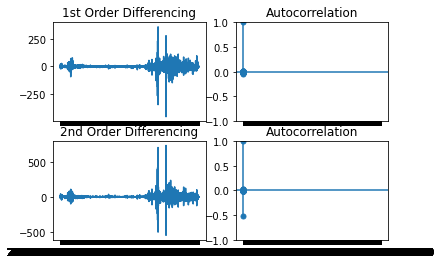

In [10]:
# We do the same thing for ETH, which is our test set
fig, axes = plt.subplots(2, 2, sharex=True)
# 1st Differencing
axes[0, 0].plot(df_eth_re['close'].diff()); axes[0, 0].set_title('1st Order Differencing')
plot_acf(df_eth_re['close'].diff().dropna(), ax=axes[0, 1])

# 2nd Differencing
axes[1, 0].plot(df_eth_re['close'].diff().diff()); axes[1, 0].set_title('2nd Order Differencing')
plot_acf(df_eth_re['close'].diff().diff().dropna(), ax=axes[1, 1])

plt.show()

In [ ]:
# from the result, we should tell that it is not good for forecast

In [111]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [11]:
'''
So we let the auto_arima decide the parameters
# Since the data is too big for our computers, 
# we will use a slice of data(10%) to get an approximate parameters to do the prediction
'''
leng = len(df_btc_re["close"])
slice_data = pd.Series()
start = 0
end = int(len(df_btc_re["close"])/100/10)
for i in range(100):
    slice_data = slice_data.append(df_btc_re["close"][start:end])
    start += int(len(df_btc_re["close"])/100)
    end += int(len(df_btc_re["close"])/100)
'''
In this way we get a data set of 10% size of the original one but from all period
I really hope Fordham has a computer lab for us to use though...
'''
model = pm.auto_arima(slice_data.to_list(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      max_order=None,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False,
                      )

print(model.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=749747.892, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=749736.529, Time=1.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=749736.144, Time=1.97 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=749736.269, Time=3.17 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=749738.258, Time=4.40 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=749739.790, Time=6.73 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=749736.354, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=749734.557, Time=1.65 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=749736.572, Time=2.93 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=749738.236, Time=3.55 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=749740.282, Time=5.97 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=749741.882, Time=9.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=749736.014, Time=1.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=749739.641, Time=3.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=749740

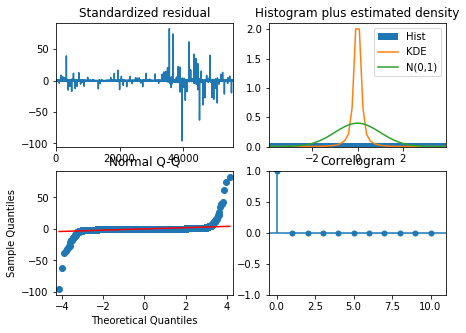

In [12]:
# Let's see model diagnose in charts
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [140]:
# Well, the outcome is bad. Residuals don't have a normal variance, distribution is skewed,
# But it's the best we can get
# So! Let's forecast!

In [112]:
from statsmodels.tsa.arima.model import ARIMA

In [130]:
# We only predict 1% length of whole time value
train = df_btc_re.iloc[:int(len(df_btc_re)*0.99), :]['close']
test = df_btc_re.iloc[int(len(df_btc_re)*0.99):, :]['close']

In [131]:
model = ARIMA(train,order = (1,1,1))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:               550588
Model:                 ARIMA(1, 1, 1)   Log Likelihood            -3097240.912
Date:                Wed, 14 Dec 2022   AIC                        6194487.824
Time:                        18:35:01   BIC                        6194521.481
Sample:                             0   HQIC                       6194497.314
                             - 550588                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2273      0.004     50.571      0.000       0.218       0.236
ma.L1         -0.2690      0.004    -60.204      0.000      -0.278      -0.260
sigma2      4504.6328      0.970   4645.610      0.000    4502.732    4506.533
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):         584284927.11
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               9.49   Skew:                            -1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                       162.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:title={'center':'Real BTC Vs. Mean of Prediction'}, xlabel='datetime'>

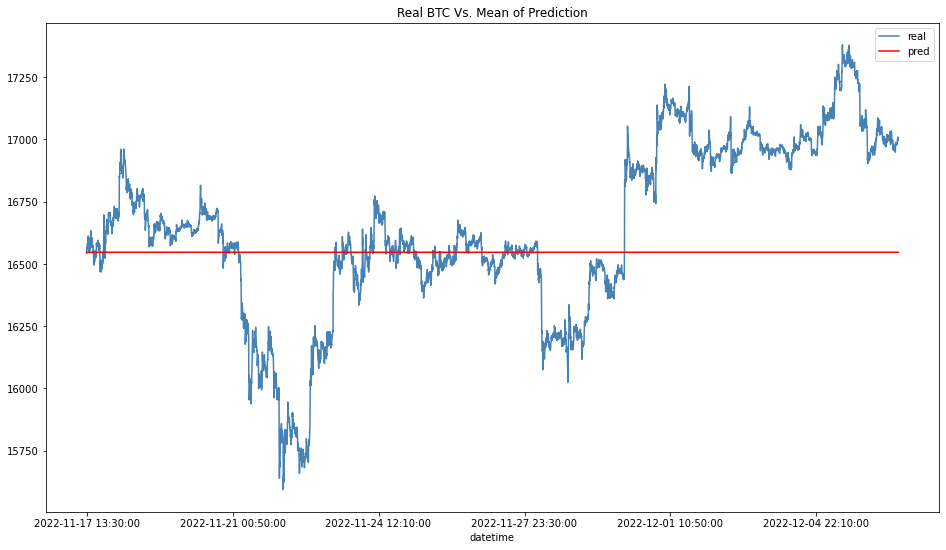

In [132]:
pred = fitted.predict(start = len(train),end= len(df_btc_re['close']) - 1)
# pred.plot(legend = True)
# test.plot(legend = True)
# plt.show()
df = pd.DataFrame([np.array(test.reset_index()['close']), np.array(pred.reset_index()['predicted_mean'])]).T
                  #columns=['real', 'pred'])#, index=test.index)
df.columns = ['real', 'pred']
df.index = test.index
df.plot(figsize=(16,9), color=['SteelBlue','Red'],
                                          title='Real BTC Vs. Mean of Prediction')

In [ ]:
'''
Because latest version of statsmodels can not give exact price as it used to do,
the ARIMA model can only give a mean data of its prediction(which we have confirmed by reading its source code)
We can build stategies with principle of buying price down and selling price up
'''

# Plan D: Using LSTM model to do the prediction

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from collections import deque
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint


In [89]:
df_btc = pd.read_csv('/Users/yanggongchi/Desktop/my_quant/ml_project_temp/data_with_features/BTC-USDT_5min_data_with_features')
df_eth = pd.read_csv('/Users/yanggongchi/Desktop/my_quant/ml_project_temp/data_with_features/ETH-USDT_5min_data_with_features')

In [90]:
df_btc_re = df_btc.copy()
df_btc_re = df_btc_re.drop(['open', 'high', 'low', 'price_change_pct', 'amount', 'volume', 'price_direction','next_close'], axis=1)
df_btc_re.set_index('datetime', inplace=True)
df_btc_re.drop(df_btc_re.columns[[0]], axis = 1, inplace = True)
df_eth_re = df_eth.copy()
df_eth_re = df_eth_re.drop(['open', 'high', 'low', 'price_change_pct', 'amount', 'volume', 'price_direction','next_close'], axis=1)
df_eth_re.set_index('datetime', inplace=True)
df_eth_re.drop(df_eth_re.columns[[0]], axis = 1, inplace = True)

In [91]:
#deal with data
def deal_coin_data(BTC,pre_days,mem_his_amt):
    BTC['label']=BTC['close'].shift(-pre_days)

    scaler=StandardScaler()
    sca_X=scaler.fit_transform(BTC.iloc[:,:-1])
    
    deq=deque(maxlen=mem_his_amt)

    X=[]
    for i in sca_X:
        deq.append(list(i))
        if len(deq)==mem_his_amt:
            X.append(list(deq))

    X_lately=X[-pre_days:]
    X=X[:-pre_days]

    y=BTC['label'].values[mem_his_amt-1:-pre_days]
    
    X=np.array(X)
    y=np.array(y)
    
    return X,y,X_lately

In [94]:
#optimize the model
pre_days=10
mem_days=[5,10,15]
lstm_layers=[1,2,3]
dense_layers=[1,2,3]
units=[8,16,32]
for the_mem_days in mem_days:
    for the_lstm_layer in lstm_layers:
        for the_dense_layer in dense_layers:
            for unit in units:
                filepath='./models/{val_mape:.2f}_{epoch:02d}_'+f'men_{the_mem_days}_lstm_{the_lstm_layer}_dense_{the_dense_layer}_unit_{unit}'
                checkpoint=ModelCheckpoint(
                    filepath=filepath,
                    save_weights_only=False,
                    monitor='val_mape',
                    mode='min',
                    save_best_only=True)
                    
                X,y,X_lately = deal_coin_data(df_btc_re,the_mem_days,pre_days)   
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,shuffle=False)

                model=Sequential()
                model.add(LSTM(unit,input_shape=X.shape[1:],activation='relu',return_sequences=True))
                model.add(Dropout(0.1))
                for i in range(the_lstm_layer):
                    model.add(LSTM(unit,activation='relu',return_sequences=True))
                    model.add(Dropout(0.1))

                model.add(LSTM(unit,activation='relu'))
                model.add(Dropout(0.1))
                for i in range(the_dense_layer ):
                    model.add(Dense(unit,activation='relu'))
                    model.add(Dropout(0.1))

                model.add(Dense(1))

                model.compile(optimizer='adam',loss='mse',metrics=['mape'])
                model.fit(X_train,y_train,batch_size=32,epochs=10,validation_data=(X_test,y_test),callbacks=[checkpoint])                          

Epoch 1/10


2022-12-13 02:36:57.073730: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


12162/12166 [============================>.] - ETA: 0s - loss: 17820724.0000 - mape: 17.6235

INFO:tensorflow:Assets written to: ./models/21.80_01_men_5_lstm_1_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/21.80_01_men_5_lstm_1_dense_1_unit_8/assets


12166/12166 [==============================] - 56s 4ms/step - loss: 17821814.0000 - mape: 17.6230 - val_loss: 58455776.0000 - val_mape: 21.8017
Epoch 2/10
12166/12166 [==============================] - 49s 4ms/step - loss: 10748669.0000 - mape: 14.4432 - val_loss: 119205824.0000 - val_mape: 28.5234
Epoch 3/10
12166/12166 [==============================] - 50s 4ms/step - loss: 9564352.0000 - mape: 13.8793 - val_loss: 108165456.0000 - val_mape: 26.7949
Epoch 4/10
12166/12166 [==============================] - 50s 4ms/step - loss: 8064493.5000 - mape: 13.1705 - val_loss: 84789096.0000 - val_mape: 23.6096
Epoch 5/10
12166/12166 [==============================] - 49s 4ms/step - loss: 7988373.5000 - mape: 13.0041 - val_loss: 124883344.0000 - val_mape: 28.7739
Epoch 6/10
12166/12166 [==============================] - 49s 4ms/step - loss: 7765377.5000 - mape: 12.9721 - val_loss: 106288200.0000 - val_mape: 26.5737
Epoch 7/10
12166/12166 [==============================] - 50s 4ms/step - loss: 78

INFO:tensorflow:Assets written to: ./models/14.75_01_men_5_lstm_1_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/14.75_01_men_5_lstm_1_dense_1_unit_8/assets


12166/12166 [==============================] - 60s 5ms/step - loss: 8596334.0000 - mape: 12.8538 - val_loss: 35104652.0000 - val_mape: 14.7534
Epoch 2/10
12166/12166 [==============================] - 55s 5ms/step - loss: 5274603.5000 - mape: 10.3834 - val_loss: 124119768.0000 - val_mape: 28.4506
Epoch 3/10
12166/12166 [==============================] - 54s 4ms/step - loss: 4484991.5000 - mape: 9.6067 - val_loss: 102213144.0000 - val_mape: 25.9479
Epoch 4/10
12166/12166 [==============================] - 54s 4ms/step - loss: 4246733.5000 - mape: 9.3769 - val_loss: 115112656.0000 - val_mape: 27.8096
Epoch 5/10
12166/12166 [==============================] - 54s 4ms/step - loss: 4095552.0000 - mape: 9.1874 - val_loss: 121036384.0000 - val_mape: 28.2462
Epoch 6/10
12166/12166 [==============================] - 54s 4ms/step - loss: 3960133.5000 - mape: 9.0308 - val_loss: 112543104.0000 - val_mape: 26.7668
Epoch 7/10
12166/12166 [==============================] - 54s 4ms/step - loss: 3809978

INFO:tensorflow:Assets written to: ./models/18.48_01_men_5_lstm_1_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/18.48_01_men_5_lstm_1_dense_1_unit_8/assets


12166/12166 [==============================] - 70s 6ms/step - loss: 5825087.5000 - mape: 10.5553 - val_loss: 52303732.0000 - val_mape: 18.4775
Epoch 2/10
12158/12166 [============================>.] - ETA: 0s - loss: 3149608.7500 - mape: 8.0128

INFO:tensorflow:Assets written to: ./models/8.63_02_men_5_lstm_1_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/8.63_02_men_5_lstm_1_dense_1_unit_8/assets


12166/12166 [==============================] - 68s 6ms/step - loss: 3149071.7500 - mape: 8.0127 - val_loss: 11759483.0000 - val_mape: 8.6279
Epoch 3/10
12166/12166 [==============================] - 64s 5ms/step - loss: 2871720.7500 - mape: 7.6627 - val_loss: 54977760.0000 - val_mape: 18.2345
Epoch 4/10
12166/12166 [==============================] - 64s 5ms/step - loss: 2793353.0000 - mape: 7.5368 - val_loss: 22915886.0000 - val_mape: 11.2546
Epoch 5/10
12166/12166 [==============================] - 64s 5ms/step - loss: 2581774.0000 - mape: 7.2983 - val_loss: 48633188.0000 - val_mape: 16.8148
Epoch 6/10
12166/12166 [==============================] - 64s 5ms/step - loss: 2559246.5000 - mape: 7.2452 - val_loss: 24730364.0000 - val_mape: 12.3871
Epoch 7/10
12166/12166 [==============================] - 64s 5ms/step - loss: 2548882.7500 - mape: 7.1703 - val_loss: 18959470.0000 - val_mape: 9.8422
Epoch 8/10
12166/12166 [==============================] - 64s 5ms/step - loss: 2483463.0000 - m

INFO:tensorflow:Assets written to: ./models/32.44_01_men_5_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/32.44_01_men_5_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 56s 4ms/step - loss: 18904218.0000 - mape: 18.7677 - val_loss: 153320384.0000 - val_mape: 32.4352
Epoch 2/10
12153/12166 [============================>.] - ETA: 0s - loss: 9464956.0000 - mape: 13.7050

INFO:tensorflow:Assets written to: ./models/31.20_02_men_5_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/31.20_02_men_5_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 54s 4ms/step - loss: 9470265.0000 - mape: 13.7036 - val_loss: 154333104.0000 - val_mape: 31.1984
Epoch 3/10
12166/12166 [==============================] - 50s 4ms/step - loss: 8000923.0000 - mape: 12.5576 - val_loss: 179877552.0000 - val_mape: 33.1091
Epoch 4/10
12162/12166 [============================>.] - ETA: 0s - loss: 7626459.0000 - mape: 12.2714

INFO:tensorflow:Assets written to: ./models/28.42_04_men_5_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/28.42_04_men_5_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 55s 4ms/step - loss: 7628445.5000 - mape: 12.2716 - val_loss: 126235552.0000 - val_mape: 28.4164
Epoch 5/10
12166/12166 [==============================] - 50s 4ms/step - loss: 7416628.5000 - mape: 12.1873 - val_loss: 154877072.0000 - val_mape: 31.5352
Epoch 6/10
12166/12166 [==============================] - 50s 4ms/step - loss: 7476775.5000 - mape: 12.2108 - val_loss: 142851808.0000 - val_mape: 30.2806
Epoch 7/10
12153/12166 [============================>.] - ETA: 0s - loss: 7395558.5000 - mape: 12.0664

INFO:tensorflow:Assets written to: ./models/27.28_07_men_5_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/27.28_07_men_5_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 54s 4ms/step - loss: 7399677.5000 - mape: 12.0659 - val_loss: 122833960.0000 - val_mape: 27.2803
Epoch 8/10
12166/12166 [==============================] - 50s 4ms/step - loss: 7534366.5000 - mape: 12.0873 - val_loss: 143627248.0000 - val_mape: 30.3228
Epoch 9/10
12166/12166 [==============================] - 50s 4ms/step - loss: 7356733.0000 - mape: 12.0102 - val_loss: 179253952.0000 - val_mape: 33.8267
Epoch 10/10
12166/12166 [==============================] - 50s 4ms/step - loss: 7232425.5000 - mape: 11.9744 - val_loss: 181129264.0000 - val_mape: 33.5963
Epoch 1/10
12164/12166 [============================>.] - ETA: 0s - loss: 9933032.0000 - mape: 13.6130

INFO:tensorflow:Assets written to: ./models/22.81_01_men_5_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/22.81_01_men_5_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 60s 5ms/step - loss: 9932428.0000 - mape: 13.6125 - val_loss: 78728744.0000 - val_mape: 22.8093
Epoch 2/10
12166/12166 [==============================] - 54s 4ms/step - loss: 5236086.0000 - mape: 10.4026 - val_loss: 98321752.0000 - val_mape: 24.2674
Epoch 3/10
12166/12166 [==============================] - 54s 4ms/step - loss: 4754404.0000 - mape: 10.0249 - val_loss: 120220304.0000 - val_mape: 27.1964
Epoch 4/10
12166/12166 [==============================] - 54s 4ms/step - loss: 4491985.0000 - mape: 9.6611 - val_loss: 110915296.0000 - val_mape: 26.4115
Epoch 5/10
12166/12166 [==============================] - 54s 4ms/step - loss: 4201044.5000 - mape: 9.4259 - val_loss: 146109488.0000 - val_mape: 30.2433
Epoch 6/10
12166/12166 [==============================] - 54s 4ms/step - loss: 4156999.7500 - mape: 9.2918 - val_loss: 127518712.0000 - val_mape: 28.6512
Epoch 7/10
12166/12166 [==============================] - 54s 4ms/step - loss: 4107847

INFO:tensorflow:Assets written to: ./models/25.67_01_men_5_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/25.67_01_men_5_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 72s 6ms/step - loss: 7037912.5000 - mape: 11.4345 - val_loss: 87859968.0000 - val_mape: 25.6703
Epoch 2/10
12158/12166 [============================>.] - ETA: 0s - loss: 3284679.7500 - mape: 8.2671

INFO:tensorflow:Assets written to: ./models/22.53_02_men_5_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/22.53_02_men_5_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 70s 6ms/step - loss: 3284435.5000 - mape: 8.2671 - val_loss: 76859776.0000 - val_mape: 22.5306
Epoch 3/10
12166/12166 [==============================] - 66s 5ms/step - loss: 2803777.2500 - mape: 7.7405 - val_loss: 156861008.0000 - val_mape: 32.0093
Epoch 4/10
12166/12166 [==============================] - 66s 5ms/step - loss: 2648146.5000 - mape: 7.5268 - val_loss: 129816336.0000 - val_mape: 28.5276
Epoch 5/10
12166/12166 [==============================] - 66s 5ms/step - loss: 2507639.5000 - mape: 7.3697 - val_loss: 175414144.0000 - val_mape: 33.3630
Epoch 6/10
12166/12166 [==============================] - 66s 5ms/step - loss: 2444266.0000 - mape: 7.2199 - val_loss: 125620664.0000 - val_mape: 28.6222
Epoch 7/10
12166/12166 [==============================] - 66s 5ms/step - loss: 2414506.2500 - mape: 7.1434 - val_loss: 134507216.0000 - val_mape: 29.3035
Epoch 8/10
12166/12166 [==============================] - 66s 5ms/step - loss: 2355729.0

INFO:tensorflow:Assets written to: ./models/36.73_01_men_5_lstm_1_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/36.73_01_men_5_lstm_1_dense_3_unit_8/assets


12166/12166 [==============================] - 57s 5ms/step - loss: 22306614.0000 - mape: 20.6513 - val_loss: 200136800.0000 - val_mape: 36.7266
Epoch 2/10
12166/12166 [==============================] - 51s 4ms/step - loss: 11825129.0000 - mape: 15.4360 - val_loss: 237480976.0000 - val_mape: 39.5895
Epoch 3/10
12166/12166 [==============================] - 51s 4ms/step - loss: 11110352.0000 - mape: 14.9276 - val_loss: 251316768.0000 - val_mape: 40.7703
Epoch 4/10
12166/12166 [==============================] - 51s 4ms/step - loss: 10577693.0000 - mape: 14.5826 - val_loss: 276829280.0000 - val_mape: 43.0803
Epoch 5/10
12166/12166 [==============================] - 51s 4ms/step - loss: 10419787.0000 - mape: 14.3039 - val_loss: 288400928.0000 - val_mape: 44.1046
Epoch 6/10
12166/12166 [==============================] - 51s 4ms/step - loss: 9563743.0000 - mape: 13.9286 - val_loss: 275399168.0000 - val_mape: 43.1258
Epoch 7/10
12166/12166 [==============================] - 51s 4ms/step - los

INFO:tensorflow:Assets written to: ./models/33.85_01_men_5_lstm_1_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/33.85_01_men_5_lstm_1_dense_3_unit_8/assets


12166/12166 [==============================] - 61s 5ms/step - loss: 14280640.0000 - mape: 17.1122 - val_loss: 175407376.0000 - val_mape: 33.8525
Epoch 2/10
12155/12166 [============================>.] - ETA: 0s - loss: 7644610.5000 - mape: 12.5911

INFO:tensorflow:Assets written to: ./models/32.15_02_men_5_lstm_1_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/32.15_02_men_5_lstm_1_dense_3_unit_8/assets


12166/12166 [==============================] - 59s 5ms/step - loss: 7642783.5000 - mape: 12.5901 - val_loss: 161857968.0000 - val_mape: 32.1526
Epoch 3/10
12166/12166 [==============================] - 55s 5ms/step - loss: 6586271.0000 - mape: 11.6364 - val_loss: 202234992.0000 - val_mape: 35.2308
Epoch 4/10
12166/12166 [==============================] - 55s 5ms/step - loss: 5953807.0000 - mape: 10.9932 - val_loss: 189730096.0000 - val_mape: 33.9295
Epoch 5/10
12166/12166 [==============================] - 55s 5ms/step - loss: 5681617.0000 - mape: 10.7309 - val_loss: 229087424.0000 - val_mape: 37.8104
Epoch 6/10
12166/12166 [==============================] - 1044s 86ms/step - loss: 5527934.5000 - mape: 10.5090 - val_loss: 209295952.0000 - val_mape: 35.7384
Epoch 7/10
12166/12166 [==============================] - 1006s 83ms/step - loss: 5208974.0000 - mape: 10.2193 - val_loss: 232671808.0000 - val_mape: 38.0435
Epoch 8/10
12166/12166 [==============================] - 1107s 91ms/step -

INFO:tensorflow:Assets written to: ./models/23.82_01_men_5_lstm_1_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/23.82_01_men_5_lstm_1_dense_3_unit_8/assets


12166/12166 [==============================] - 1036s 85ms/step - loss: 8573104.0000 - mape: 13.1590 - val_loss: 88248712.0000 - val_mape: 23.8197
Epoch 2/10
12166/12166 [==============================] - 1085s 89ms/step - loss: 5011414.5000 - mape: 10.2187 - val_loss: 145280880.0000 - val_mape: 31.0486
Epoch 3/10
12166/12166 [==============================] - 1118s 92ms/step - loss: 4380882.0000 - mape: 9.5273 - val_loss: 163709968.0000 - val_mape: 32.8623
Epoch 4/10
12166/12166 [==============================] - 1957s 161ms/step - loss: 4024911.2500 - mape: 9.0743 - val_loss: 156160960.0000 - val_mape: 31.2013
Epoch 5/10
12166/12166 [==============================] - 974s 80ms/step - loss: 3831715.0000 - mape: 8.8229 - val_loss: 142055184.0000 - val_mape: 29.6111
Epoch 6/10
12166/12166 [==============================] - 2070s 170ms/step - loss: 3763774.0000 - mape: 8.7163 - val_loss: 130165968.0000 - val_mape: 28.4577
Epoch 7/10
12166/12166 [==============================] - 1101s 90m

INFO:tensorflow:Assets written to: ./models/15.28_01_men_5_lstm_2_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/15.28_01_men_5_lstm_2_dense_1_unit_8/assets


12166/12166 [==============================] - 1100s 90ms/step - loss: 16470600.0000 - mape: 17.4300 - val_loss: 40670848.0000 - val_mape: 15.2792
Epoch 2/10
12162/12166 [============================>.] - ETA: 0s - loss: 8213379.0000 - mape: 12.8260

INFO:tensorflow:Assets written to: ./models/15.05_02_men_5_lstm_2_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/15.05_02_men_5_lstm_2_dense_1_unit_8/assets


12166/12166 [==============================] - 1937s 159ms/step - loss: 8212448.5000 - mape: 12.8264 - val_loss: 43413836.0000 - val_mape: 15.0516
Epoch 3/10
12166/12166 [==============================] - 963s 79ms/step - loss: 7630580.5000 - mape: 12.5994 - val_loss: 47536040.0000 - val_mape: 16.2560
Epoch 4/10
12166/12166 [==============================] - 993s 82ms/step - loss: 7192884.0000 - mape: 12.3378 - val_loss: 74014872.0000 - val_mape: 20.2065
Epoch 5/10
12166/12166 [==============================] - 1918s 158ms/step - loss: 7007043.0000 - mape: 12.1137 - val_loss: 119161312.0000 - val_mape: 24.7604
Epoch 6/10
12166/12166 [==============================] - 1124s 92ms/step - loss: 6937084.0000 - mape: 12.0308 - val_loss: 116850008.0000 - val_mape: 26.0561
Epoch 7/10
12166/12166 [==============================] - 975s 80ms/step - loss: 6721605.5000 - mape: 11.8623 - val_loss: 69730064.0000 - val_mape: 20.1066
Epoch 8/10
12166/12166 [==============================] - 952s 78ms/

INFO:tensorflow:Assets written to: ./models/17.29_01_men_5_lstm_2_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/17.29_01_men_5_lstm_2_dense_1_unit_8/assets


12166/12166 [==============================] - 79s 6ms/step - loss: 9171093.0000 - mape: 13.8854 - val_loss: 55137988.0000 - val_mape: 17.2904
Epoch 2/10
12166/12166 [==============================] - ETA: 0s - loss: 4991188.0000 - mape: 10.2007

INFO:tensorflow:Assets written to: ./models/15.57_02_men_5_lstm_2_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/15.57_02_men_5_lstm_2_dense_1_unit_8/assets


12166/12166 [==============================] - 77s 6ms/step - loss: 4991188.0000 - mape: 10.2007 - val_loss: 42416128.0000 - val_mape: 15.5710
Epoch 3/10
12166/12166 [==============================] - 72s 6ms/step - loss: 4516725.5000 - mape: 9.6879 - val_loss: 88687952.0000 - val_mape: 22.3075
Epoch 4/10
12166/12166 [==============================] - 72s 6ms/step - loss: 4401063.0000 - mape: 9.4714 - val_loss: 151030912.0000 - val_mape: 30.7707
Epoch 5/10
12166/12166 [==============================] - 72s 6ms/step - loss: 4045648.0000 - mape: 9.1610 - val_loss: 104300008.0000 - val_mape: 25.0652
Epoch 6/10
12166/12166 [==============================] - 73s 6ms/step - loss: 4049711.7500 - mape: 9.0905 - val_loss: 170220768.0000 - val_mape: 31.8536
Epoch 7/10
12166/12166 [==============================] - 76s 6ms/step - loss: 4006805.2500 - mape: 9.0355 - val_loss: 151007632.0000 - val_mape: 30.0000
Epoch 8/10
12166/12166 [==============================] - 81s 7ms/step - loss: 3897306.7

INFO:tensorflow:Assets written to: ./models/14.69_01_men_5_lstm_2_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/14.69_01_men_5_lstm_2_dense_1_unit_8/assets


12166/12166 [==============================] - 101s 8ms/step - loss: 6465808.0000 - mape: 11.1611 - val_loss: 40395840.0000 - val_mape: 14.6899
Epoch 2/10
12166/12166 [==============================] - 93s 8ms/step - loss: 3151881.2500 - mape: 8.1715 - val_loss: 83532992.0000 - val_mape: 22.3886
Epoch 3/10
12160/12166 [============================>.] - ETA: 0s - loss: 2799361.7500 - mape: 7.6809

INFO:tensorflow:Assets written to: ./models/13.65_03_men_5_lstm_2_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/13.65_03_men_5_lstm_2_dense_1_unit_8/assets


12166/12166 [==============================] - 98s 8ms/step - loss: 2799538.7500 - mape: 7.6806 - val_loss: 39684340.0000 - val_mape: 13.6526
Epoch 4/10
12166/12166 [==============================] - 93s 8ms/step - loss: 2574339.0000 - mape: 7.4058 - val_loss: 58398488.0000 - val_mape: 17.6322
Epoch 5/10
12165/12166 [============================>.] - ETA: 0s - loss: 2622624.2500 - mape: 7.3032

INFO:tensorflow:Assets written to: ./models/12.92_05_men_5_lstm_2_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/12.92_05_men_5_lstm_2_dense_1_unit_8/assets


12166/12166 [==============================] - 97s 8ms/step - loss: 2622814.7500 - mape: 7.3033 - val_loss: 34171716.0000 - val_mape: 12.9229
Epoch 6/10
12165/12166 [============================>.] - ETA: 0s - loss: 2586325.5000 - mape: 7.3166

INFO:tensorflow:Assets written to: ./models/10.34_06_men_5_lstm_2_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/10.34_06_men_5_lstm_2_dense_1_unit_8/assets


12166/12166 [==============================] - 98s 8ms/step - loss: 2586273.0000 - mape: 7.3166 - val_loss: 23184110.0000 - val_mape: 10.3357
Epoch 7/10
12166/12166 [==============================] - 89s 7ms/step - loss: 2563853.5000 - mape: 7.3008 - val_loss: 45556472.0000 - val_mape: 15.3834
Epoch 8/10
12166/12166 [==============================] - 90s 7ms/step - loss: 2480170.7500 - mape: 7.2299 - val_loss: 39335168.0000 - val_mape: 13.4532
Epoch 9/10
12166/12166 [==============================] - 94s 8ms/step - loss: 2458688.2500 - mape: 7.1691 - val_loss: 27556446.0000 - val_mape: 10.7097
Epoch 10/10
12166/12166 [==============================] - 109s 9ms/step - loss: 2405722.0000 - mape: 7.1137 - val_loss: 43453324.0000 - val_mape: 15.1684
Epoch 1/10
12158/12166 [============================>.] - ETA: 0s - loss: 16809988.0000 - mape: 18.2085

INFO:tensorflow:Assets written to: ./models/29.17_01_men_5_lstm_2_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/29.17_01_men_5_lstm_2_dense_2_unit_8/assets


12166/12166 [==============================] - 85s 7ms/step - loss: 16804064.0000 - mape: 18.2051 - val_loss: 124786960.0000 - val_mape: 29.1713
Epoch 2/10
12166/12166 [==============================] - 72s 6ms/step - loss: 8513990.0000 - mape: 13.0336 - val_loss: 193093600.0000 - val_mape: 35.3427
Epoch 3/10
12166/12166 [==============================] - 72s 6ms/step - loss: 7825895.0000 - mape: 12.3855 - val_loss: 142401984.0000 - val_mape: 31.1261
Epoch 4/10
12166/12166 [==============================] - 72s 6ms/step - loss: 7462675.5000 - mape: 12.1972 - val_loss: 215728016.0000 - val_mape: 37.3490
Epoch 5/10
12166/12166 [==============================] - 72s 6ms/step - loss: 7209182.0000 - mape: 12.0160 - val_loss: 154556096.0000 - val_mape: 31.3014
Epoch 6/10
12166/12166 [==============================] - 72s 6ms/step - loss: 6962366.5000 - mape: 11.9738 - val_loss: 188943408.0000 - val_mape: 35.0152
Epoch 7/10
12166/12166 [==============================] - 72s 6ms/step - loss: 7

INFO:tensorflow:Assets written to: ./models/34.33_01_men_5_lstm_2_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/34.33_01_men_5_lstm_2_dense_2_unit_8/assets


12166/12166 [==============================] - 87s 7ms/step - loss: 10146498.0000 - mape: 14.0973 - val_loss: 193990896.0000 - val_mape: 34.3305
Epoch 2/10
12166/12166 [==============================] - 81s 7ms/step - loss: 4896976.5000 - mape: 10.0024 - val_loss: 213098224.0000 - val_mape: 37.2582
Epoch 3/10
12166/12166 [==============================] - 102s 8ms/step - loss: 4079941.2500 - mape: 9.1807 - val_loss: 226457952.0000 - val_mape: 37.9256
Epoch 4/10
12166/12166 [==============================] - 107s 9ms/step - loss: 3806283.7500 - mape: 8.8330 - val_loss: 256305200.0000 - val_mape: 40.2101
Epoch 5/10
12166/12166 [==============================] - 105s 9ms/step - loss: 3652638.7500 - mape: 8.6940 - val_loss: 262330496.0000 - val_mape: 40.6206
Epoch 6/10
12164/12166 [============================>.] - ETA: 0s - loss: 3570371.2500 - mape: 8.5554

INFO:tensorflow:Assets written to: ./models/30.13_06_men_5_lstm_2_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/30.13_06_men_5_lstm_2_dense_2_unit_8/assets


12166/12166 [==============================] - 114s 9ms/step - loss: 3570113.5000 - mape: 8.5554 - val_loss: 149412704.0000 - val_mape: 30.1297
Epoch 7/10
12166/12166 [==============================] - 109s 9ms/step - loss: 3563108.2500 - mape: 8.4563 - val_loss: 233942384.0000 - val_mape: 38.2310
Epoch 8/10
12166/12166 [==============================] - 110s 9ms/step - loss: 3482987.0000 - mape: 8.3727 - val_loss: 217211600.0000 - val_mape: 36.8434
Epoch 9/10
12166/12166 [==============================] - 109s 9ms/step - loss: 3502228.0000 - mape: 8.3235 - val_loss: 191400080.0000 - val_mape: 34.3482
Epoch 10/10
12166/12166 [==============================] - 115s 9ms/step - loss: 3377324.0000 - mape: 8.2897 - val_loss: 194678336.0000 - val_mape: 35.0473
Epoch 1/10
12166/12166 [==============================] - ETA: 0s - loss: 7723499.0000 - mape: 12.4347

INFO:tensorflow:Assets written to: ./models/28.69_01_men_5_lstm_2_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/28.69_01_men_5_lstm_2_dense_2_unit_8/assets


12166/12166 [==============================] - 145s 12ms/step - loss: 7723499.0000 - mape: 12.4347 - val_loss: 137843968.0000 - val_mape: 28.6873
Epoch 2/10
12163/12166 [============================>.] - ETA: 0s - loss: 3248281.0000 - mape: 8.5218

INFO:tensorflow:Assets written to: ./models/25.62_02_men_5_lstm_2_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/25.62_02_men_5_lstm_2_dense_2_unit_8/assets


12166/12166 [==============================] - 141s 12ms/step - loss: 3248410.0000 - mape: 8.5222 - val_loss: 117547344.0000 - val_mape: 25.6159
Epoch 3/10
12162/12166 [============================>.] - ETA: 0s - loss: 2899004.7500 - mape: 7.9483

INFO:tensorflow:Assets written to: ./models/21.84_03_men_5_lstm_2_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/21.84_03_men_5_lstm_2_dense_2_unit_8/assets


12166/12166 [==============================] - 141s 12ms/step - loss: 2899079.7500 - mape: 7.9486 - val_loss: 93842352.0000 - val_mape: 21.8443
Epoch 4/10
12166/12166 [==============================] - 135s 11ms/step - loss: 2699574.5000 - mape: 7.6566 - val_loss: 169926880.0000 - val_mape: 31.1011
Epoch 5/10
12166/12166 [==============================] - 143s 12ms/step - loss: 2516983.5000 - mape: 7.4291 - val_loss: 129999080.0000 - val_mape: 27.0583
Epoch 6/10
12166/12166 [==============================] - 141s 12ms/step - loss: 2419753.2500 - mape: 7.2198 - val_loss: 171756320.0000 - val_mape: 31.8669
Epoch 7/10
12166/12166 [==============================] - 148s 12ms/step - loss: 2373847.7500 - mape: 7.1128 - val_loss: 170514288.0000 - val_mape: 31.8429
Epoch 8/10
12166/12166 [==============================] - 151s 12ms/step - loss: 2370209.2500 - mape: 7.1052 - val_loss: 167449984.0000 - val_mape: 31.7252
Epoch 9/10
12166/12166 [==============================] - 101s 8ms/step - lo

INFO:tensorflow:Assets written to: ./models/34.61_01_men_5_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/34.61_01_men_5_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 75s 6ms/step - loss: 23501672.0000 - mape: 23.7055 - val_loss: 187110448.0000 - val_mape: 34.6070
Epoch 2/10
12166/12166 [==============================] - ETA: 0s - loss: 8770845.0000 - mape: 13.4006

INFO:tensorflow:Assets written to: ./models/32.09_02_men_5_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/32.09_02_men_5_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 75s 6ms/step - loss: 8770845.0000 - mape: 13.4006 - val_loss: 176935952.0000 - val_mape: 32.0879
Epoch 3/10
12166/12166 [==============================] - 71s 6ms/step - loss: 7860951.0000 - mape: 12.6877 - val_loss: 195426048.0000 - val_mape: 32.9482
Epoch 4/10
12166/12166 [==============================] - 73s 6ms/step - loss: 7437918.0000 - mape: 12.3656 - val_loss: 235296608.0000 - val_mape: 36.5636
Epoch 5/10
12166/12166 [==============================] - 73s 6ms/step - loss: 7230445.0000 - mape: 12.1976 - val_loss: 244696960.0000 - val_mape: 37.5814
Epoch 6/10
12166/12166 [==============================] - 73s 6ms/step - loss: 7040257.0000 - mape: 11.9151 - val_loss: 199937456.0000 - val_mape: 34.0305
Epoch 7/10
12166/12166 [==============================] - 74s 6ms/step - loss: 6749932.5000 - mape: 11.6733 - val_loss: 203410640.0000 - val_mape: 34.6351
Epoch 8/10
12166/12166 [==============================] - 72s 6ms/step - loss: 66

INFO:tensorflow:Assets written to: ./models/43.58_01_men_5_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/43.58_01_men_5_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 89s 7ms/step - loss: 13652546.0000 - mape: 16.9783 - val_loss: 267663328.0000 - val_mape: 43.5848
Epoch 2/10
12166/12166 [==============================] - 81s 7ms/step - loss: 5715074.5000 - mape: 10.8247 - val_loss: 323643584.0000 - val_mape: 46.7716
Epoch 3/10
12166/12166 [==============================] - 82s 7ms/step - loss: 4709335.5000 - mape: 9.8164 - val_loss: 330545024.0000 - val_mape: 47.3059
Epoch 4/10
12166/12166 [==============================] - 81s 7ms/step - loss: 4305366.5000 - mape: 9.4033 - val_loss: 308175008.0000 - val_mape: 44.8550
Epoch 5/10
12166/12166 [==============================] - 80s 7ms/step - loss: 4157834.0000 - mape: 9.2446 - val_loss: 310803680.0000 - val_mape: 45.3203
Epoch 6/10
12163/12166 [============================>.] - ETA: 0s - loss: 3979990.2500 - mape: 9.0474

INFO:tensorflow:Assets written to: ./models/42.30_06_men_5_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/42.30_06_men_5_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 86s 7ms/step - loss: 3979876.5000 - mape: 9.0474 - val_loss: 267800080.0000 - val_mape: 42.2983
Epoch 7/10
12166/12166 [==============================] - 1071s 88ms/step - loss: 3894968.7500 - mape: 8.9322 - val_loss: 312704512.0000 - val_mape: 45.3868
Epoch 8/10
12166/12166 [==============================] - 1776s 146ms/step - loss: 3840465.7500 - mape: 8.8538 - val_loss: 342524800.0000 - val_mape: 47.4501
Epoch 9/10
12166/12166 [==============================] - 255s 21ms/step - loss: 3852845.7500 - mape: 8.8675 - val_loss: 328355136.0000 - val_mape: 46.3043
Epoch 10/10
12160/12166 [============================>.] - ETA: 0s - loss: 3763204.5000 - mape: 8.7729

INFO:tensorflow:Assets written to: ./models/40.96_10_men_5_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/40.96_10_men_5_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 77s 6ms/step - loss: 3762778.0000 - mape: 8.7739 - val_loss: 256756304.0000 - val_mape: 40.9607
Epoch 1/10
12166/12166 [==============================] - ETA: 0s - loss: 8153591.0000 - mape: 12.7093

INFO:tensorflow:Assets written to: ./models/26.69_01_men_5_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/26.69_01_men_5_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 95s 8ms/step - loss: 8153591.0000 - mape: 12.7093 - val_loss: 120740104.0000 - val_mape: 26.6857
Epoch 2/10
12166/12166 [==============================] - 90s 7ms/step - loss: 4413328.5000 - mape: 9.6030 - val_loss: 131601320.0000 - val_mape: 27.6994
Epoch 3/10
12166/12166 [==============================] - 88s 7ms/step - loss: 3689140.2500 - mape: 8.8147 - val_loss: 159489776.0000 - val_mape: 30.3403
Epoch 4/10
12166/12166 [==============================] - 88s 7ms/step - loss: 3379822.0000 - mape: 8.4546 - val_loss: 152176256.0000 - val_mape: 30.2726
Epoch 5/10
12166/12166 [==============================] - 93s 8ms/step - loss: 3195935.0000 - mape: 8.1636 - val_loss: 150568512.0000 - val_mape: 30.2964
Epoch 6/10
12166/12166 [==============================] - 88s 7ms/step - loss: 3067299.0000 - mape: 7.9970 - val_loss: 165618544.0000 - val_mape: 30.9521
Epoch 7/10
12166/12166 [==============================] - 87s 7ms/step - loss: 3007510

INFO:tensorflow:Assets written to: ./models/25.88_01_men_5_lstm_3_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/25.88_01_men_5_lstm_3_dense_1_unit_8/assets


12166/12166 [==============================] - 91s 7ms/step - loss: 21305216.0000 - mape: 19.6827 - val_loss: 117033792.0000 - val_mape: 25.8792
Epoch 2/10
12159/12166 [============================>.] - ETA: 0s - loss: 11027704.0000 - mape: 14.5176

INFO:tensorflow:Assets written to: ./models/16.35_02_men_5_lstm_3_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/16.35_02_men_5_lstm_3_dense_1_unit_8/assets


12166/12166 [==============================] - 89s 7ms/step - loss: 11030621.0000 - mape: 14.5184 - val_loss: 46698484.0000 - val_mape: 16.3545
Epoch 3/10
12166/12166 [==============================] - 85s 7ms/step - loss: 10247135.0000 - mape: 14.1527 - val_loss: 96811008.0000 - val_mape: 23.8791
Epoch 4/10
12166/12166 [==============================] - 84s 7ms/step - loss: 9766437.0000 - mape: 13.9020 - val_loss: 127824696.0000 - val_mape: 26.7181
Epoch 5/10
12166/12166 [==============================] - 85s 7ms/step - loss: 9333897.0000 - mape: 13.6036 - val_loss: 129750056.0000 - val_mape: 27.3568
Epoch 6/10
12166/12166 [==============================] - 86s 7ms/step - loss: 8964147.0000 - mape: 13.4472 - val_loss: 164894336.0000 - val_mape: 29.8082
Epoch 7/10
12166/12166 [==============================] - 86s 7ms/step - loss: 8769188.0000 - mape: 13.3862 - val_loss: 101755888.0000 - val_mape: 23.1944
Epoch 8/10
12166/12166 [==============================] - 86s 7ms/step - loss: 92

INFO:tensorflow:Assets written to: ./models/24.98_01_men_5_lstm_3_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/24.98_01_men_5_lstm_3_dense_1_unit_8/assets


12166/12166 [==============================] - 98s 8ms/step - loss: 10857332.0000 - mape: 14.5599 - val_loss: 92643680.0000 - val_mape: 24.9840
Epoch 2/10
12166/12166 [==============================] - 88s 7ms/step - loss: 6438831.0000 - mape: 11.4577 - val_loss: 175884672.0000 - val_mape: 32.9496
Epoch 3/10
12166/12166 [==============================] - 88s 7ms/step - loss: 5834762.5000 - mape: 11.0654 - val_loss: 141261728.0000 - val_mape: 29.4089
Epoch 4/10
12166/12166 [==============================] - 88s 7ms/step - loss: 5645193.5000 - mape: 10.8649 - val_loss: 132222304.0000 - val_mape: 28.0850
Epoch 5/10
12166/12166 [==============================] - 88s 7ms/step - loss: 5535984.0000 - mape: 10.7926 - val_loss: 170318688.0000 - val_mape: 32.0022
Epoch 6/10
12166/12166 [==============================] - 88s 7ms/step - loss: 5464190.0000 - mape: 10.7255 - val_loss: 189644896.0000 - val_mape: 33.8558
Epoch 7/10
12166/12166 [==============================] - 87s 7ms/step - loss: 53

INFO:tensorflow:Assets written to: ./models/12.39_01_men_5_lstm_3_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/12.39_01_men_5_lstm_3_dense_1_unit_8/assets


12166/12166 [==============================] - 118s 9ms/step - loss: 6402957.0000 - mape: 11.1553 - val_loss: 36731008.0000 - val_mape: 12.3868
Epoch 2/10
12166/12166 [==============================] - 109s 9ms/step - loss: 3381596.2500 - mape: 8.4793 - val_loss: 99571552.0000 - val_mape: 22.5547
Epoch 3/10
12166/12166 [==============================] - 108s 9ms/step - loss: 3032720.5000 - mape: 8.0134 - val_loss: 74197008.0000 - val_mape: 18.7338
Epoch 4/10
12166/12166 [==============================] - 110s 9ms/step - loss: 2920129.0000 - mape: 7.8088 - val_loss: 67262776.0000 - val_mape: 16.7047
Epoch 5/10
12166/12166 [==============================] - 111s 9ms/step - loss: 2806572.7500 - mape: 7.6628 - val_loss: 65595804.0000 - val_mape: 17.9964
Epoch 6/10
12166/12166 [==============================] - 116s 9ms/step - loss: 2819577.5000 - mape: 7.6230 - val_loss: 54315340.0000 - val_mape: 17.1235
Epoch 7/10
12166/12166 [==============================] - 115s 9ms/step - loss: 274137

INFO:tensorflow:Assets written to: ./models/11.59_09_men_5_lstm_3_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/11.59_09_men_5_lstm_3_dense_1_unit_8/assets


12166/12166 [==============================] - 122s 10ms/step - loss: 2708342.7500 - mape: 7.4944 - val_loss: 34367908.0000 - val_mape: 11.5851
Epoch 10/10
12166/12166 [==============================] - 116s 10ms/step - loss: 2491170.0000 - mape: 7.5689 - val_loss: 43244160.0000 - val_mape: 13.6198
Epoch 1/10
12164/12166 [============================>.] - ETA: 0s - loss: 21421574.0000 - mape: 22.7837

INFO:tensorflow:Assets written to: ./models/27.89_01_men_5_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/27.89_01_men_5_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 96s 8ms/step - loss: 21419610.0000 - mape: 22.7828 - val_loss: 134537120.0000 - val_mape: 27.8880
Epoch 2/10
12166/12166 [==============================] - 86s 7ms/step - loss: 9651634.0000 - mape: 14.2761 - val_loss: 146249008.0000 - val_mape: 28.5411
Epoch 3/10
12166/12166 [==============================] - 86s 7ms/step - loss: 9006452.0000 - mape: 13.8179 - val_loss: 205830208.0000 - val_mape: 34.4169
Epoch 4/10
12166/12166 [==============================] - 88s 7ms/step - loss: 8228760.5000 - mape: 13.2614 - val_loss: 217231968.0000 - val_mape: 35.3694
Epoch 5/10
12166/12166 [==============================] - 86s 7ms/step - loss: 8040938.0000 - mape: 12.9948 - val_loss: 287770400.0000 - val_mape: 42.1476
Epoch 6/10
12166/12166 [==============================] - 84s 7ms/step - loss: 7978853.5000 - mape: 12.7489 - val_loss: 257712816.0000 - val_mape: 38.7720
Epoch 7/10
12166/12166 [==============================] - 86s 7ms/step - loss: 7

INFO:tensorflow:Assets written to: ./models/40.92_01_men_5_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/40.92_01_men_5_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 103s 8ms/step - loss: 12814585.0000 - mape: 16.1255 - val_loss: 242413808.0000 - val_mape: 40.9192
Epoch 2/10
12166/12166 [==============================] - 94s 8ms/step - loss: 6180810.0000 - mape: 11.3008 - val_loss: 297387456.0000 - val_mape: 44.1759
Epoch 3/10
12159/12166 [============================>.] - ETA: 0s - loss: 5371241.0000 - mape: 10.5492

INFO:tensorflow:Assets written to: ./models/39.94_03_men_5_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/39.94_03_men_5_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 98s 8ms/step - loss: 5371113.5000 - mape: 10.5496 - val_loss: 244862192.0000 - val_mape: 39.9425
Epoch 4/10
12166/12166 [==============================] - ETA: 0s - loss: 5212133.0000 - mape: 10.2998

INFO:tensorflow:Assets written to: ./models/37.08_04_men_5_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/37.08_04_men_5_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 99s 8ms/step - loss: 5212133.0000 - mape: 10.2998 - val_loss: 212613664.0000 - val_mape: 37.0752
Epoch 5/10
12166/12166 [==============================] - 93s 8ms/step - loss: 5051202.5000 - mape: 10.0487 - val_loss: 243547168.0000 - val_mape: 38.6940
Epoch 6/10
12166/12166 [==============================] - 93s 8ms/step - loss: 4855035.0000 - mape: 9.9599 - val_loss: 258757520.0000 - val_mape: 40.0994
Epoch 7/10
12166/12166 [==============================] - 92s 8ms/step - loss: 4816219.5000 - mape: 9.8864 - val_loss: 231026032.0000 - val_mape: 37.5489
Epoch 8/10
12166/12166 [==============================] - 91s 7ms/step - loss: 4909675.5000 - mape: 9.9296 - val_loss: 239385472.0000 - val_mape: 38.7164
Epoch 9/10
12165/12166 [============================>.] - ETA: 0s - loss: 4790716.5000 - mape: 9.8119

INFO:tensorflow:Assets written to: ./models/35.26_09_men_5_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/35.26_09_men_5_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 101s 8ms/step - loss: 4790614.5000 - mape: 9.8120 - val_loss: 203828320.0000 - val_mape: 35.2637
Epoch 10/10
12166/12166 [==============================] - 93s 8ms/step - loss: 4701415.0000 - mape: 9.7254 - val_loss: 254597296.0000 - val_mape: 39.0965
Epoch 1/10
12166/12166 [==============================] - ETA: 0s - loss: 6730966.0000 - mape: 11.2354

INFO:tensorflow:Assets written to: ./models/29.88_01_men_5_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/29.88_01_men_5_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 121s 10ms/step - loss: 6730966.0000 - mape: 11.2354 - val_loss: 155713344.0000 - val_mape: 29.8803
Epoch 2/10
12165/12166 [============================>.] - ETA: 0s - loss: 3324721.2500 - mape: 8.4512

INFO:tensorflow:Assets written to: ./models/28.62_02_men_5_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/28.62_02_men_5_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 119s 10ms/step - loss: 3324777.7500 - mape: 8.4512 - val_loss: 137986272.0000 - val_mape: 28.6188
Epoch 3/10
12162/12166 [============================>.] - ETA: 0s - loss: 2916356.0000 - mape: 7.9163

INFO:tensorflow:Assets written to: ./models/27.47_03_men_5_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/27.47_03_men_5_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 119s 10ms/step - loss: 2916788.0000 - mape: 7.9162 - val_loss: 140823472.0000 - val_mape: 27.4687
Epoch 4/10
12166/12166 [==============================] - ETA: 0s - loss: 2644478.7500 - mape: 7.5671

INFO:tensorflow:Assets written to: ./models/25.95_04_men_5_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/25.95_04_men_5_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 118s 10ms/step - loss: 2644478.7500 - mape: 7.5671 - val_loss: 120884224.0000 - val_mape: 25.9492
Epoch 5/10
12162/12166 [============================>.] - ETA: 0s - loss: 2469052.0000 - mape: 7.2578

INFO:tensorflow:Assets written to: ./models/22.19_05_men_5_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/22.19_05_men_5_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 118s 10ms/step - loss: 2469272.7500 - mape: 7.2580 - val_loss: 92166248.0000 - val_mape: 22.1913
Epoch 6/10
12166/12166 [==============================] - 111s 9ms/step - loss: 2329879.7500 - mape: 7.0702 - val_loss: 97153664.0000 - val_mape: 22.5830
Epoch 7/10
12166/12166 [==============================] - 110s 9ms/step - loss: 2296201.7500 - mape: 6.9819 - val_loss: 120045032.0000 - val_mape: 25.8869
Epoch 8/10
12166/12166 [==============================] - 110s 9ms/step - loss: 2149768.2500 - mape: 6.8383 - val_loss: 113495464.0000 - val_mape: 24.7838
Epoch 9/10
12166/12166 [==============================] - 112s 9ms/step - loss: 2096367.5000 - mape: 6.7814 - val_loss: 123942904.0000 - val_mape: 26.0422
Epoch 10/10
12166/12166 [==============================] - 112s 9ms/step - loss: 2115402.7500 - mape: 6.7324 - val_loss: 95184040.0000 - val_mape: 22.6246
Epoch 1/10
12162/12166 [============================>.] - ETA: 0s - loss: 23508966

INFO:tensorflow:Assets written to: ./models/35.57_01_men_5_lstm_3_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/35.57_01_men_5_lstm_3_dense_3_unit_8/assets


12166/12166 [==============================] - 102s 8ms/step - loss: 23507412.0000 - mape: 22.1818 - val_loss: 202409312.0000 - val_mape: 35.5681
Epoch 2/10
12166/12166 [==============================] - 88s 7ms/step - loss: 15743650.0000 - mape: 18.2024 - val_loss: 210326576.0000 - val_mape: 36.1852
Epoch 3/10
12166/12166 [==============================] - 84s 7ms/step - loss: 14798710.0000 - mape: 17.6373 - val_loss: 257335680.0000 - val_mape: 39.9370
Epoch 4/10
12163/12166 [============================>.] - ETA: 0s - loss: 14250187.0000 - mape: 17.2442

INFO:tensorflow:Assets written to: ./models/31.45_04_men_5_lstm_3_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/31.45_04_men_5_lstm_3_dense_3_unit_8/assets


12166/12166 [==============================] - 90s 7ms/step - loss: 14251123.0000 - mape: 17.2446 - val_loss: 158501024.0000 - val_mape: 31.4539
Epoch 5/10
12166/12166 [==============================] - 85s 7ms/step - loss: 13977306.0000 - mape: 17.0358 - val_loss: 241020416.0000 - val_mape: 38.5749
Epoch 6/10
12166/12166 [==============================] - 85s 7ms/step - loss: 13579460.0000 - mape: 16.9045 - val_loss: 261394352.0000 - val_mape: 40.3873
Epoch 7/10
12166/12166 [==============================] - 87s 7ms/step - loss: 13004587.0000 - mape: 16.4423 - val_loss: 280007648.0000 - val_mape: 41.9904
Epoch 8/10
12166/12166 [==============================] - 85s 7ms/step - loss: 9858260.0000 - mape: 14.0660 - val_loss: 334818208.0000 - val_mape: 46.2316
Epoch 9/10
12166/12166 [==============================] - 84s 7ms/step - loss: 8897988.0000 - mape: 13.3716 - val_loss: 309783104.0000 - val_mape: 44.1379
Epoch 10/10
12166/12166 [==============================] - 84s 7ms/step - los

INFO:tensorflow:Assets written to: ./models/46.98_01_men_5_lstm_3_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/46.98_01_men_5_lstm_3_dense_3_unit_8/assets


12166/12166 [==============================] - 104s 8ms/step - loss: 14836496.0000 - mape: 17.6045 - val_loss: 329239424.0000 - val_mape: 46.9775
Epoch 2/10
12163/12166 [============================>.] - ETA: 0s - loss: 6809947.0000 - mape: 11.9823

INFO:tensorflow:Assets written to: ./models/45.13_02_men_5_lstm_3_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/45.13_02_men_5_lstm_3_dense_3_unit_8/assets


12166/12166 [==============================] - 104s 9ms/step - loss: 6809666.0000 - mape: 11.9818 - val_loss: 308910912.0000 - val_mape: 45.1258
Epoch 3/10
12166/12166 [==============================] - 98s 8ms/step - loss: 5816453.0000 - mape: 10.9403 - val_loss: 410812128.0000 - val_mape: 52.0455
Epoch 4/10
12166/12166 [==============================] - 97s 8ms/step - loss: 5397845.5000 - mape: 10.4993 - val_loss: 365871936.0000 - val_mape: 49.3594
Epoch 5/10
12166/12166 [==============================] - 93s 8ms/step - loss: 5261683.0000 - mape: 10.3127 - val_loss: 384055680.0000 - val_mape: 49.7100
Epoch 6/10
12166/12166 [==============================] - 94s 8ms/step - loss: 4929782.5000 - mape: 10.0114 - val_loss: 399619392.0000 - val_mape: 50.8441
Epoch 7/10
12166/12166 [==============================] - 94s 8ms/step - loss: 4626323.5000 - mape: 9.6958 - val_loss: 322964480.0000 - val_mape: 45.9722
Epoch 8/10
12166/12166 [==============================] - 90s 7ms/step - loss: 44

INFO:tensorflow:Assets written to: ./models/30.91_01_men_5_lstm_3_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/30.91_01_men_5_lstm_3_dense_3_unit_8/assets


12166/12166 [==============================] - 120s 10ms/step - loss: 8063421.5000 - mape: 12.5248 - val_loss: 155891312.0000 - val_mape: 30.9132
Epoch 2/10
12166/12166 [==============================] - 118s 10ms/step - loss: 3979315.0000 - mape: 9.2032 - val_loss: 201066560.0000 - val_mape: 35.0319
Epoch 3/10
12166/12166 [==============================] - 117s 10ms/step - loss: 3338999.5000 - mape: 8.4245 - val_loss: 175240688.0000 - val_mape: 32.1487
Epoch 4/10
12166/12166 [==============================] - 113s 9ms/step - loss: 3161880.0000 - mape: 8.1849 - val_loss: 171587440.0000 - val_mape: 31.4645
Epoch 5/10
12162/12166 [============================>.] - ETA: 0s - loss: 3019509.0000 - mape: 7.9441

INFO:tensorflow:Assets written to: ./models/26.88_05_men_5_lstm_3_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/26.88_05_men_5_lstm_3_dense_3_unit_8/assets


12166/12166 [==============================] - 120s 10ms/step - loss: 3019118.7500 - mape: 7.9442 - val_loss: 130803312.0000 - val_mape: 26.8835
Epoch 6/10
12166/12166 [==============================] - 118s 10ms/step - loss: 2857909.2500 - mape: 7.8084 - val_loss: 144059200.0000 - val_mape: 28.7919
Epoch 7/10
12166/12166 [==============================] - 113s 9ms/step - loss: 2861485.7500 - mape: 7.7713 - val_loss: 146260576.0000 - val_mape: 28.7667
Epoch 8/10
12166/12166 [==============================] - 112s 9ms/step - loss: 2764107.5000 - mape: 7.6230 - val_loss: 136613520.0000 - val_mape: 28.4535
Epoch 9/10
12166/12166 [==============================] - 109s 9ms/step - loss: 2718670.2500 - mape: 7.5931 - val_loss: 164584576.0000 - val_mape: 30.9304
Epoch 10/10
12166/12166 [==============================] - 110s 9ms/step - loss: 2715429.7500 - mape: 7.6885 - val_loss: 149683152.0000 - val_mape: 30.2736
Epoch 1/10
12156/12166 [============================>.] - ETA: 0s - loss: 1575

INFO:tensorflow:Assets written to: ./models/23.39_01_men_10_lstm_1_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/23.39_01_men_10_lstm_1_dense_1_unit_8/assets


12166/12166 [==============================] - 56s 4ms/step - loss: 15753396.0000 - mape: 17.9145 - val_loss: 80396168.0000 - val_mape: 23.3899
Epoch 2/10
12158/12166 [============================>.] - ETA: 0s - loss: 8032064.0000 - mape: 12.8471

INFO:tensorflow:Assets written to: ./models/20.72_02_men_10_lstm_1_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/20.72_02_men_10_lstm_1_dense_1_unit_8/assets


12166/12166 [==============================] - 54s 4ms/step - loss: 8031311.5000 - mape: 12.8470 - val_loss: 66757720.0000 - val_mape: 20.7223
Epoch 3/10
12158/12166 [============================>.] - ETA: 0s - loss: 6436161.5000 - mape: 11.4292

INFO:tensorflow:Assets written to: ./models/15.78_03_men_10_lstm_1_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/15.78_03_men_10_lstm_1_dense_1_unit_8/assets


12166/12166 [==============================] - 54s 4ms/step - loss: 6436580.5000 - mape: 11.4294 - val_loss: 36178436.0000 - val_mape: 15.7757
Epoch 4/10
12166/12166 [==============================] - 50s 4ms/step - loss: 6187099.5000 - mape: 11.1462 - val_loss: 36042876.0000 - val_mape: 16.4559
Epoch 5/10
12166/12166 [==============================] - 50s 4ms/step - loss: 5976416.0000 - mape: 11.0787 - val_loss: 64406776.0000 - val_mape: 21.0468
Epoch 6/10
12166/12166 [==============================] - 50s 4ms/step - loss: 5960681.0000 - mape: 11.0090 - val_loss: 89475168.0000 - val_mape: 24.6002
Epoch 7/10
12166/12166 [==============================] - 50s 4ms/step - loss: 5910623.5000 - mape: 11.0185 - val_loss: 59470876.0000 - val_mape: 20.2419
Epoch 8/10
12166/12166 [==============================] - 50s 4ms/step - loss: 5881769.5000 - mape: 11.0202 - val_loss: 50684812.0000 - val_mape: 18.6238
Epoch 9/10
12166/12166 [==============================] - 49s 4ms/step - loss: 5893297.

INFO:tensorflow:Assets written to: ./models/18.56_01_men_10_lstm_1_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/18.56_01_men_10_lstm_1_dense_1_unit_8/assets


12166/12166 [==============================] - 59s 5ms/step - loss: 9877119.0000 - mape: 13.6740 - val_loss: 53856632.0000 - val_mape: 18.5582
Epoch 2/10
12166/12166 [==============================] - 53s 4ms/step - loss: 5394301.0000 - mape: 10.6365 - val_loss: 106127584.0000 - val_mape: 26.4234
Epoch 3/10
12166/12166 [==============================] - 53s 4ms/step - loss: 4762383.5000 - mape: 9.9881 - val_loss: 109122344.0000 - val_mape: 26.9353
Epoch 4/10
12166/12166 [==============================] - 53s 4ms/step - loss: 4335226.0000 - mape: 9.5472 - val_loss: 74977272.0000 - val_mape: 21.6570
Epoch 5/10
12166/12166 [==============================] - 53s 4ms/step - loss: 4272241.5000 - mape: 9.5125 - val_loss: 82629696.0000 - val_mape: 23.2509
Epoch 6/10
12166/12166 [==============================] - 53s 4ms/step - loss: 4138324.2500 - mape: 9.3321 - val_loss: 89232744.0000 - val_mape: 23.9173
Epoch 7/10
12166/12166 [==============================] - 56s 5ms/step - loss: 4129825.50

INFO:tensorflow:Assets written to: ./models/19.65_01_men_10_lstm_1_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/19.65_01_men_10_lstm_1_dense_1_unit_8/assets


12166/12166 [==============================] - 72s 6ms/step - loss: 5503889.5000 - mape: 10.1696 - val_loss: 61560004.0000 - val_mape: 19.6528
Epoch 2/10
12166/12166 [==============================] - ETA: 0s - loss: 2552032.7500 - mape: 7.4081

INFO:tensorflow:Assets written to: ./models/13.34_02_men_10_lstm_1_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/13.34_02_men_10_lstm_1_dense_1_unit_8/assets


12166/12166 [==============================] - 70s 6ms/step - loss: 2552032.7500 - mape: 7.4081 - val_loss: 29067572.0000 - val_mape: 13.3431
Epoch 3/10
12166/12166 [==============================] - 66s 5ms/step - loss: 2170131.7500 - mape: 6.8440 - val_loss: 48218644.0000 - val_mape: 17.2716
Epoch 4/10
12166/12166 [==============================] - 65s 5ms/step - loss: 2046224.1250 - mape: 6.6305 - val_loss: 79850520.0000 - val_mape: 21.8646
Epoch 5/10
12166/12166 [==============================] - 65s 5ms/step - loss: 1945243.5000 - mape: 6.4607 - val_loss: 73086384.0000 - val_mape: 21.3028
Epoch 6/10
12166/12166 [==============================] - 65s 5ms/step - loss: 1897421.5000 - mape: 6.4219 - val_loss: 88843288.0000 - val_mape: 23.0666
Epoch 7/10
12166/12166 [==============================] - 64s 5ms/step - loss: 1907928.5000 - mape: 6.3888 - val_loss: 63162960.0000 - val_mape: 19.4709
Epoch 8/10
12166/12166 [==============================] - 66s 5ms/step - loss: 1873996.8750 -

INFO:tensorflow:Assets written to: ./models/24.84_01_men_10_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/24.84_01_men_10_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 2217s 182ms/step - loss: 22304922.0000 - mape: 19.8161 - val_loss: 85914264.0000 - val_mape: 24.8370
Epoch 2/10
12166/12166 [==============================] - 346s 28ms/step - loss: 9719297.0000 - mape: 13.9020 - val_loss: 169719648.0000 - val_mape: 33.7180
Epoch 3/10
12166/12166 [==============================] - 49s 4ms/step - loss: 8530423.0000 - mape: 13.0460 - val_loss: 164068752.0000 - val_mape: 33.7188
Epoch 4/10
12166/12166 [==============================] - 49s 4ms/step - loss: 8343554.5000 - mape: 12.8951 - val_loss: 189654224.0000 - val_mape: 35.7342
Epoch 5/10
12166/12166 [==============================] - 49s 4ms/step - loss: 8227796.0000 - mape: 12.7751 - val_loss: 183500592.0000 - val_mape: 35.0368
Epoch 6/10
12166/12166 [==============================] - 49s 4ms/step - loss: 8019305.5000 - mape: 12.7662 - val_loss: 192949200.0000 - val_mape: 35.6693
Epoch 7/10
12166/12166 [==============================] - 49s 4ms/step - lo

INFO:tensorflow:Assets written to: ./models/32.07_01_men_10_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/32.07_01_men_10_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 59s 5ms/step - loss: 10744256.0000 - mape: 14.2201 - val_loss: 138642656.0000 - val_mape: 32.0658
Epoch 2/10
12160/12166 [============================>.] - ETA: 0s - loss: 5481903.0000 - mape: 10.6905

INFO:tensorflow:Assets written to: ./models/31.52_02_men_10_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/31.52_02_men_10_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 57s 5ms/step - loss: 5481326.5000 - mape: 10.6910 - val_loss: 144756688.0000 - val_mape: 31.5195
Epoch 3/10
12163/12166 [============================>.] - ETA: 0s - loss: 4949402.5000 - mape: 10.2177

INFO:tensorflow:Assets written to: ./models/28.80_03_men_10_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/28.80_03_men_10_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 547s 45ms/step - loss: 4949304.5000 - mape: 10.2179 - val_loss: 124891048.0000 - val_mape: 28.8002
Epoch 4/10
12166/12166 [==============================] - 56s 5ms/step - loss: 4833645.5000 - mape: 10.0058 - val_loss: 179312576.0000 - val_mape: 34.8499
Epoch 5/10
12166/12166 [==============================] - 54s 4ms/step - loss: 4664639.0000 - mape: 9.8542 - val_loss: 173607328.0000 - val_mape: 33.9330
Epoch 6/10
12166/12166 [==============================] - 57s 5ms/step - loss: 4578262.0000 - mape: 9.7408 - val_loss: 170017664.0000 - val_mape: 33.6754
Epoch 7/10
12166/12166 [==============================] - 57s 5ms/step - loss: 4520710.0000 - mape: 9.6921 - val_loss: 211210928.0000 - val_mape: 37.3008
Epoch 8/10
12166/12166 [==============================] - 57s 5ms/step - loss: 4414587.5000 - mape: 9.5913 - val_loss: 175197888.0000 - val_mape: 33.9142
Epoch 9/10
12166/12166 [==============================] - 56s 5ms/step - loss: 4439

INFO:tensorflow:Assets written to: ./models/24.08_01_men_10_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/24.08_01_men_10_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 75s 6ms/step - loss: 7206973.0000 - mape: 11.6093 - val_loss: 83842448.0000 - val_mape: 24.0846
Epoch 2/10
12165/12166 [============================>.] - ETA: 0s - loss: 3458153.0000 - mape: 8.4795

INFO:tensorflow:Assets written to: ./models/23.01_02_men_10_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/23.01_02_men_10_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 72s 6ms/step - loss: 3458113.7500 - mape: 8.4795 - val_loss: 79678840.0000 - val_mape: 23.0051
Epoch 3/10
12166/12166 [==============================] - 66s 5ms/step - loss: 2768809.7500 - mape: 7.6803 - val_loss: 123738920.0000 - val_mape: 27.7427
Epoch 4/10
12166/12166 [==============================] - 67s 6ms/step - loss: 2526639.0000 - mape: 7.3784 - val_loss: 131109368.0000 - val_mape: 29.0836
Epoch 5/10
12166/12166 [==============================] - 67s 6ms/step - loss: 2430600.5000 - mape: 7.1987 - val_loss: 159080752.0000 - val_mape: 31.6174
Epoch 6/10
12166/12166 [==============================] - 67s 5ms/step - loss: 2337096.0000 - mape: 7.0824 - val_loss: 138625328.0000 - val_mape: 30.0225
Epoch 7/10
12166/12166 [==============================] - 66s 5ms/step - loss: 2304315.2500 - mape: 6.9536 - val_loss: 126682640.0000 - val_mape: 28.1351
Epoch 8/10
12166/12166 [==============================] - 67s 5ms/step - loss: 2158269.5

INFO:tensorflow:Assets written to: ./models/39.31_01_men_10_lstm_1_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/39.31_01_men_10_lstm_1_dense_3_unit_8/assets


12166/12166 [==============================] - 58s 5ms/step - loss: 17943816.0000 - mape: 18.0457 - val_loss: 222435920.0000 - val_mape: 39.3096
Epoch 2/10
12166/12166 [==============================] - 52s 4ms/step - loss: 9739710.0000 - mape: 13.7949 - val_loss: 242072448.0000 - val_mape: 40.7463
Epoch 3/10
12166/12166 [==============================] - 52s 4ms/step - loss: 9299097.0000 - mape: 13.5067 - val_loss: 253079984.0000 - val_mape: 41.3768
Epoch 4/10
12166/12166 [==============================] - 52s 4ms/step - loss: 9139628.0000 - mape: 13.3733 - val_loss: 293712160.0000 - val_mape: 44.1904
Epoch 5/10
12166/12166 [==============================] - 51s 4ms/step - loss: 8920942.0000 - mape: 13.1955 - val_loss: 241940320.0000 - val_mape: 39.9322
Epoch 6/10
12166/12166 [==============================] - 52s 4ms/step - loss: 8565154.0000 - mape: 12.9995 - val_loss: 248954240.0000 - val_mape: 40.5053
Epoch 7/10
12157/12166 [============================>.] - ETA: 0s - loss: 872525

INFO:tensorflow:Assets written to: ./models/35.67_07_men_10_lstm_1_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/35.67_07_men_10_lstm_1_dense_3_unit_8/assets


12166/12166 [==============================] - 55s 5ms/step - loss: 8725859.0000 - mape: 12.9626 - val_loss: 191335344.0000 - val_mape: 35.6736
Epoch 8/10
12166/12166 [==============================] - 52s 4ms/step - loss: 8626547.0000 - mape: 12.9086 - val_loss: 245925536.0000 - val_mape: 40.2140
Epoch 9/10
12166/12166 [==============================] - 51s 4ms/step - loss: 8470548.0000 - mape: 12.8509 - val_loss: 291442496.0000 - val_mape: 43.7038
Epoch 10/10
12166/12166 [==============================] - 51s 4ms/step - loss: 8381939.0000 - mape: 12.8324 - val_loss: 264514320.0000 - val_mape: 41.5680
Epoch 1/10
12160/12166 [============================>.] - ETA: 0s - loss: 12827729.0000 - mape: 16.7719

INFO:tensorflow:Assets written to: ./models/35.03_01_men_10_lstm_1_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/35.03_01_men_10_lstm_1_dense_3_unit_8/assets


12166/12166 [==============================] - 61s 5ms/step - loss: 12824416.0000 - mape: 16.7697 - val_loss: 193648976.0000 - val_mape: 35.0300
Epoch 2/10
12156/12166 [============================>.] - ETA: 0s - loss: 5290792.0000 - mape: 10.4816

INFO:tensorflow:Assets written to: ./models/33.73_02_men_10_lstm_1_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/33.73_02_men_10_lstm_1_dense_3_unit_8/assets


12166/12166 [==============================] - 60s 5ms/step - loss: 5292320.0000 - mape: 10.4814 - val_loss: 193143840.0000 - val_mape: 33.7253
Epoch 3/10
12166/12166 [==============================] - 56s 5ms/step - loss: 4606679.0000 - mape: 9.7379 - val_loss: 189909632.0000 - val_mape: 33.8066
Epoch 4/10
12154/12166 [============================>.] - ETA: 0s - loss: 4300437.0000 - mape: 9.4182

INFO:tensorflow:Assets written to: ./models/33.54_04_men_10_lstm_1_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/33.54_04_men_10_lstm_1_dense_3_unit_8/assets


12166/12166 [==============================] - 61s 5ms/step - loss: 4302536.5000 - mape: 9.4190 - val_loss: 188922832.0000 - val_mape: 33.5366
Epoch 5/10
12166/12166 [==============================] - 57s 5ms/step - loss: 4155158.0000 - mape: 9.2404 - val_loss: 210492288.0000 - val_mape: 35.8466
Epoch 6/10
12166/12166 [==============================] - 55s 5ms/step - loss: 4061059.7500 - mape: 9.0728 - val_loss: 222853728.0000 - val_mape: 37.4430
Epoch 7/10
12166/12166 [==============================] - 55s 5ms/step - loss: 4076313.5000 - mape: 9.0368 - val_loss: 217092944.0000 - val_mape: 36.8898
Epoch 8/10
12154/12166 [============================>.] - ETA: 0s - loss: 3983779.0000 - mape: 8.9518

INFO:tensorflow:Assets written to: ./models/32.66_08_men_10_lstm_1_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/32.66_08_men_10_lstm_1_dense_3_unit_8/assets


12166/12166 [==============================] - 59s 5ms/step - loss: 3983672.5000 - mape: 8.9511 - val_loss: 179645888.0000 - val_mape: 32.6646
Epoch 9/10
12166/12166 [==============================] - 56s 5ms/step - loss: 3902478.5000 - mape: 8.8711 - val_loss: 222570432.0000 - val_mape: 37.0355
Epoch 10/10
12166/12166 [==============================] - 56s 5ms/step - loss: 3850387.7500 - mape: 8.8045 - val_loss: 211604192.0000 - val_mape: 35.8288
Epoch 1/10
12163/12166 [============================>.] - ETA: 0s - loss: 6991627.0000 - mape: 11.7886

INFO:tensorflow:Assets written to: ./models/33.74_01_men_10_lstm_1_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/33.74_01_men_10_lstm_1_dense_3_unit_8/assets


12166/12166 [==============================] - 74s 6ms/step - loss: 6991343.0000 - mape: 11.7882 - val_loss: 173676544.0000 - val_mape: 33.7437
Epoch 2/10
12162/12166 [============================>.] - ETA: 0s - loss: 3470341.0000 - mape: 8.4590

INFO:tensorflow:Assets written to: ./models/30.01_02_men_10_lstm_1_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/30.01_02_men_10_lstm_1_dense_3_unit_8/assets


12166/12166 [==============================] - 72s 6ms/step - loss: 3470825.5000 - mape: 8.4588 - val_loss: 140359472.0000 - val_mape: 30.0092
Epoch 3/10
12166/12166 [==============================] - 66s 5ms/step - loss: 2932082.7500 - mape: 7.7437 - val_loss: 166094352.0000 - val_mape: 32.9746
Epoch 4/10
12166/12166 [==============================] - 66s 5ms/step - loss: 2687917.2500 - mape: 7.3923 - val_loss: 174872176.0000 - val_mape: 33.3117
Epoch 5/10
12166/12166 [==============================] - 66s 5ms/step - loss: 2629975.0000 - mape: 7.2831 - val_loss: 162140512.0000 - val_mape: 31.9967
Epoch 6/10
12166/12166 [==============================] - 67s 5ms/step - loss: 2509418.2500 - mape: 7.1679 - val_loss: 185288992.0000 - val_mape: 34.0137
Epoch 7/10
12166/12166 [==============================] - 67s 6ms/step - loss: 2513361.0000 - mape: 7.1367 - val_loss: 181055936.0000 - val_mape: 33.7586
Epoch 8/10
12166/12166 [==============================] - 68s 6ms/step - loss: 2488854.

INFO:tensorflow:Assets written to: ./models/24.16_01_men_10_lstm_2_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/24.16_01_men_10_lstm_2_dense_1_unit_8/assets


12166/12166 [==============================] - 75s 6ms/step - loss: 16460020.0000 - mape: 17.8420 - val_loss: 101243536.0000 - val_mape: 24.1638
Epoch 2/10
12166/12166 [==============================] - 66s 5ms/step - loss: 6726423.0000 - mape: 12.0944 - val_loss: 138247680.0000 - val_mape: 29.3640
Epoch 3/10
12166/12166 [==============================] - 66s 5ms/step - loss: 6059468.5000 - mape: 11.2359 - val_loss: 138617424.0000 - val_mape: 29.0384
Epoch 4/10
12166/12166 [==============================] - 67s 6ms/step - loss: 5756028.0000 - mape: 10.9067 - val_loss: 114453000.0000 - val_mape: 26.9811
Epoch 5/10
12166/12166 [==============================] - 67s 5ms/step - loss: 6787773.5000 - mape: 11.8734 - val_loss: 115001728.0000 - val_mape: 27.0965
Epoch 6/10
12166/12166 [==============================] - 67s 6ms/step - loss: 6738302.5000 - mape: 11.6944 - val_loss: 120327768.0000 - val_mape: 27.8408
Epoch 7/10
12166/12166 [==============================] - 67s 6ms/step - loss: 6

INFO:tensorflow:Assets written to: ./models/23.64_01_men_10_lstm_2_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/23.64_01_men_10_lstm_2_dense_1_unit_8/assets


12166/12166 [==============================] - 80s 6ms/step - loss: 12734217.0000 - mape: 16.4510 - val_loss: 104700216.0000 - val_mape: 23.6411
Epoch 2/10
12166/12166 [==============================] - 71s 6ms/step - loss: 6402434.0000 - mape: 11.6663 - val_loss: 113454160.0000 - val_mape: 26.1164
Epoch 3/10
12166/12166 [==============================] - 71s 6ms/step - loss: 5834056.5000 - mape: 10.9946 - val_loss: 115800296.0000 - val_mape: 25.6773
Epoch 4/10
12166/12166 [==============================] - 71s 6ms/step - loss: 5763078.0000 - mape: 10.8608 - val_loss: 99347176.0000 - val_mape: 24.1979
Epoch 5/10
12166/12166 [==============================] - 72s 6ms/step - loss: 5877264.5000 - mape: 10.9285 - val_loss: 165725584.0000 - val_mape: 31.5630
Epoch 6/10
12166/12166 [==============================] - 72s 6ms/step - loss: 5588367.5000 - mape: 10.6855 - val_loss: 124933320.0000 - val_mape: 27.2027
Epoch 7/10
12166/12166 [==============================] - 72s 6ms/step - loss: 51

INFO:tensorflow:Assets written to: ./models/17.44_01_men_10_lstm_2_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/17.44_01_men_10_lstm_2_dense_1_unit_8/assets


12166/12166 [==============================] - 97s 8ms/step - loss: 6226105.0000 - mape: 10.6495 - val_loss: 48213176.0000 - val_mape: 17.4420
Epoch 2/10
12166/12166 [==============================] - 87s 7ms/step - loss: 3150987.7500 - mape: 8.1176 - val_loss: 83639560.0000 - val_mape: 21.5344
Epoch 3/10
12162/12166 [============================>.] - ETA: 0s - loss: 2774562.7500 - mape: 7.6521

INFO:tensorflow:Assets written to: ./models/13.94_03_men_10_lstm_2_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/13.94_03_men_10_lstm_2_dense_1_unit_8/assets


12166/12166 [==============================] - 95s 8ms/step - loss: 2774240.0000 - mape: 7.6523 - val_loss: 44227284.0000 - val_mape: 13.9426
Epoch 4/10
12166/12166 [==============================] - 86s 7ms/step - loss: 2604068.5000 - mape: 7.3697 - val_loss: 50065872.0000 - val_mape: 15.8126
Epoch 5/10
12166/12166 [==============================] - 85s 7ms/step - loss: 2541685.5000 - mape: 7.2575 - val_loss: 51227624.0000 - val_mape: 15.2883
Epoch 6/10
12166/12166 [==============================] - 85s 7ms/step - loss: 2492392.7500 - mape: 7.1427 - val_loss: 50535820.0000 - val_mape: 15.3031
Epoch 7/10
12166/12166 [==============================] - 87s 7ms/step - loss: 2515346.2500 - mape: 7.1359 - val_loss: 41980448.0000 - val_mape: 14.2820
Epoch 8/10
12166/12166 [==============================] - 85s 7ms/step - loss: 2478970.2500 - mape: 7.0690 - val_loss: 49562048.0000 - val_mape: 16.4732
Epoch 9/10
12166/12166 [==============================] - 85s 7ms/step - loss: 2453721.2500 -

INFO:tensorflow:Assets written to: ./models/12.20_10_men_10_lstm_2_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/12.20_10_men_10_lstm_2_dense_1_unit_8/assets


12166/12166 [==============================] - 91s 7ms/step - loss: 2409989.0000 - mape: 6.9823 - val_loss: 32192736.0000 - val_mape: 12.2008
Epoch 1/10
12158/12166 [============================>.] - ETA: 0s - loss: 18802580.0000 - mape: 19.5918

INFO:tensorflow:Assets written to: ./models/34.09_01_men_10_lstm_2_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/34.09_01_men_10_lstm_2_dense_2_unit_8/assets


12166/12166 [==============================] - 74s 6ms/step - loss: 18796780.0000 - mape: 19.5882 - val_loss: 172997056.0000 - val_mape: 34.0919
Epoch 2/10
12166/12166 [==============================] - 66s 5ms/step - loss: 9389258.0000 - mape: 13.7846 - val_loss: 190104784.0000 - val_mape: 34.7030
Epoch 3/10
12166/12166 [==============================] - 67s 6ms/step - loss: 8169689.0000 - mape: 12.9203 - val_loss: 201051136.0000 - val_mape: 36.2164
Epoch 4/10
12166/12166 [==============================] - 68s 6ms/step - loss: 7767489.5000 - mape: 12.5566 - val_loss: 197303824.0000 - val_mape: 35.0470
Epoch 5/10
12166/12166 [==============================] - 67s 6ms/step - loss: 7493237.5000 - mape: 12.4372 - val_loss: 213891008.0000 - val_mape: 37.4833
Epoch 6/10
12166/12166 [==============================] - 67s 5ms/step - loss: 7530572.0000 - mape: 12.4564 - val_loss: 240553824.0000 - val_mape: 38.7319
Epoch 7/10
12158/12166 [============================>.] - ETA: 0s - loss: 751156

INFO:tensorflow:Assets written to: ./models/33.06_07_men_10_lstm_2_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/33.06_07_men_10_lstm_2_dense_2_unit_8/assets


12166/12166 [==============================] - 73s 6ms/step - loss: 7515367.5000 - mape: 12.3621 - val_loss: 167590144.0000 - val_mape: 33.0641
Epoch 8/10
12166/12166 [==============================] - 67s 5ms/step - loss: 7337577.5000 - mape: 12.3331 - val_loss: 223781984.0000 - val_mape: 37.7478
Epoch 9/10
12166/12166 [==============================] - 68s 6ms/step - loss: 7287145.5000 - mape: 12.2719 - val_loss: 236552064.0000 - val_mape: 38.9983
Epoch 10/10
12166/12166 [==============================] - 72s 6ms/step - loss: 7306642.0000 - mape: 12.2335 - val_loss: 178931760.0000 - val_mape: 33.9114
Epoch 1/10
12161/12166 [============================>.] - ETA: 0s - loss: 13815944.0000 - mape: 15.8026

INFO:tensorflow:Assets written to: ./models/30.99_01_men_10_lstm_2_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/30.99_01_men_10_lstm_2_dense_2_unit_8/assets


12166/12166 [==============================] - 82s 7ms/step - loss: 13813508.0000 - mape: 15.8010 - val_loss: 134749792.0000 - val_mape: 30.9871
Epoch 2/10
12166/12166 [==============================] - 72s 6ms/step - loss: 5984819.0000 - mape: 11.0638 - val_loss: 232944560.0000 - val_mape: 37.9691
Epoch 3/10
12166/12166 [==============================] - 72s 6ms/step - loss: 5264026.5000 - mape: 10.3812 - val_loss: 186360368.0000 - val_mape: 34.5613
Epoch 4/10
12165/12166 [============================>.] - ETA: 0s - loss: 5078025.0000 - mape: 10.1827

INFO:tensorflow:Assets written to: ./models/30.86_04_men_10_lstm_2_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/30.86_04_men_10_lstm_2_dense_2_unit_8/assets


12166/12166 [==============================] - 77s 6ms/step - loss: 5077972.5000 - mape: 10.1827 - val_loss: 145201760.0000 - val_mape: 30.8575
Epoch 5/10
12166/12166 [==============================] - 71s 6ms/step - loss: 4937658.5000 - mape: 10.0057 - val_loss: 198485632.0000 - val_mape: 35.6764
Epoch 6/10
12166/12166 [==============================] - 72s 6ms/step - loss: 4957447.0000 - mape: 9.8922 - val_loss: 194340416.0000 - val_mape: 34.7423
Epoch 7/10
12166/12166 [==============================] - 75s 6ms/step - loss: 4769246.5000 - mape: 9.7992 - val_loss: 199778656.0000 - val_mape: 35.6047
Epoch 8/10
12166/12166 [==============================] - 71s 6ms/step - loss: 4312678.0000 - mape: 9.2569 - val_loss: 172194288.0000 - val_mape: 32.5643
Epoch 9/10
12166/12166 [==============================] - 73s 6ms/step - loss: 4156288.5000 - mape: 9.0492 - val_loss: 166537392.0000 - val_mape: 32.1161
Epoch 10/10
12166/12166 [==============================] - 73s 6ms/step - loss: 41124

INFO:tensorflow:Assets written to: ./models/21.66_01_men_10_lstm_2_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/21.66_01_men_10_lstm_2_dense_2_unit_8/assets


12166/12166 [==============================] - 96s 8ms/step - loss: 7386613.5000 - mape: 12.0055 - val_loss: 89527088.0000 - val_mape: 21.6552
Epoch 2/10
12159/12166 [============================>.] - ETA: 0s - loss: 3657166.7500 - mape: 8.8907

INFO:tensorflow:Assets written to: ./models/21.33_02_men_10_lstm_2_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/21.33_02_men_10_lstm_2_dense_2_unit_8/assets


12166/12166 [==============================] - 93s 8ms/step - loss: 3657286.0000 - mape: 8.8908 - val_loss: 77288256.0000 - val_mape: 21.3333
Epoch 3/10
12166/12166 [==============================] - 87s 7ms/step - loss: 3054592.0000 - mape: 8.0671 - val_loss: 90444280.0000 - val_mape: 22.5326
Epoch 4/10
12166/12166 [==============================] - 87s 7ms/step - loss: 2806269.0000 - mape: 7.6922 - val_loss: 107176144.0000 - val_mape: 24.9053
Epoch 5/10
12166/12166 [==============================] - 87s 7ms/step - loss: 2660345.5000 - mape: 7.4656 - val_loss: 99720040.0000 - val_mape: 23.4061
Epoch 6/10
12166/12166 [==============================] - 91s 7ms/step - loss: 2581189.5000 - mape: 7.3643 - val_loss: 110891968.0000 - val_mape: 25.6309
Epoch 7/10
12166/12166 [==============================] - 89s 7ms/step - loss: 2520933.7500 - mape: 7.2673 - val_loss: 109218528.0000 - val_mape: 25.2688
Epoch 8/10
12166/12166 [==============================] - 91s 7ms/step - loss: 2479160.500

INFO:tensorflow:Assets written to: ./models/35.66_01_men_10_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/35.66_01_men_10_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 79s 6ms/step - loss: 23163760.0000 - mape: 21.3159 - val_loss: 211176512.0000 - val_mape: 35.6568
Epoch 2/10
12166/12166 [==============================] - 69s 6ms/step - loss: 12599504.0000 - mape: 15.8322 - val_loss: 253033232.0000 - val_mape: 38.9188
Epoch 3/10
12166/12166 [==============================] - 70s 6ms/step - loss: 10616302.0000 - mape: 14.4629 - val_loss: 236279872.0000 - val_mape: 38.1801
Epoch 4/10
12166/12166 [==============================] - 72s 6ms/step - loss: 9856944.0000 - mape: 13.8155 - val_loss: 316612512.0000 - val_mape: 44.2276
Epoch 5/10
12166/12166 [==============================] - 75s 6ms/step - loss: 9177886.0000 - mape: 13.4174 - val_loss: 274462816.0000 - val_mape: 41.9245
Epoch 6/10
12166/12166 [==============================] - 67s 6ms/step - loss: 8862562.0000 - mape: 13.1980 - val_loss: 301182080.0000 - val_mape: 43.8665
Epoch 7/10
12166/12166 [==============================] - 73s 6ms/step - loss:

INFO:tensorflow:Assets written to: ./models/42.19_01_men_10_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/42.19_01_men_10_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 82s 7ms/step - loss: 13632260.0000 - mape: 16.0696 - val_loss: 267053424.0000 - val_mape: 42.1890
Epoch 2/10
12160/12166 [============================>.] - ETA: 0s - loss: 7212871.5000 - mape: 12.1903

INFO:tensorflow:Assets written to: ./models/38.39_02_men_10_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/38.39_02_men_10_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 79s 7ms/step - loss: 7213139.5000 - mape: 12.1900 - val_loss: 225917392.0000 - val_mape: 38.3904
Epoch 3/10
12166/12166 [==============================] - 75s 6ms/step - loss: 6344903.0000 - mape: 11.4465 - val_loss: 345237120.0000 - val_mape: 47.0846
Epoch 4/10
12166/12166 [==============================] - 73s 6ms/step - loss: 6027883.0000 - mape: 11.1136 - val_loss: 243230784.0000 - val_mape: 40.2115
Epoch 5/10
12164/12166 [============================>.] - ETA: 0s - loss: 5786420.5000 - mape: 10.8238

INFO:tensorflow:Assets written to: ./models/37.74_05_men_10_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/37.74_05_men_10_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 80s 7ms/step - loss: 5786180.5000 - mape: 10.8236 - val_loss: 221044496.0000 - val_mape: 37.7397
Epoch 6/10
12166/12166 [==============================] - 76s 6ms/step - loss: 5408987.5000 - mape: 10.5662 - val_loss: 284666048.0000 - val_mape: 42.8313
Epoch 7/10
12166/12166 [==============================] - 76s 6ms/step - loss: 5342692.5000 - mape: 10.4624 - val_loss: 272709696.0000 - val_mape: 41.7845
Epoch 8/10
12166/12166 [==============================] - 80s 7ms/step - loss: 5177316.0000 - mape: 10.2789 - val_loss: 260581312.0000 - val_mape: 40.9826
Epoch 9/10
12166/12166 [==============================] - 80s 7ms/step - loss: 5150923.0000 - mape: 10.1945 - val_loss: 255577488.0000 - val_mape: 40.2502
Epoch 10/10
12166/12166 [==============================] - 74s 6ms/step - loss: 4964836.5000 - mape: 10.1450 - val_loss: 275981664.0000 - val_mape: 41.8823
Epoch 1/10
12161/12166 [============================>.] - ETA: 0s - loss: 839623

INFO:tensorflow:Assets written to: ./models/36.08_01_men_10_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/36.08_01_men_10_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 96s 8ms/step - loss: 8395362.0000 - mape: 12.4156 - val_loss: 201417376.0000 - val_mape: 36.0762
Epoch 2/10
12166/12166 [==============================] - 89s 7ms/step - loss: 3896365.2500 - mape: 9.1073 - val_loss: 249173712.0000 - val_mape: 39.1587
Epoch 3/10
12166/12166 [==============================] - 88s 7ms/step - loss: 3407488.7500 - mape: 8.4830 - val_loss: 259643024.0000 - val_mape: 40.3089
Epoch 4/10
12165/12166 [============================>.] - ETA: 0s - loss: 3077032.7500 - mape: 8.0990

INFO:tensorflow:Assets written to: ./models/35.00_04_men_10_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/35.00_04_men_10_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 99s 8ms/step - loss: 3077004.7500 - mape: 8.0991 - val_loss: 203116608.0000 - val_mape: 35.0025
Epoch 5/10
12166/12166 [==============================] - 91s 7ms/step - loss: 2981153.0000 - mape: 7.9415 - val_loss: 251870048.0000 - val_mape: 39.5473
Epoch 6/10
12166/12166 [==============================] - 89s 7ms/step - loss: 2869766.7500 - mape: 7.7863 - val_loss: 270691904.0000 - val_mape: 41.0953
Epoch 7/10
12166/12166 [==============================] - 91s 7ms/step - loss: 2793970.2500 - mape: 7.6974 - val_loss: 250079712.0000 - val_mape: 39.5023
Epoch 8/10
12166/12166 [==============================] - 88s 7ms/step - loss: 2769594.2500 - mape: 7.6290 - val_loss: 259903904.0000 - val_mape: 39.8769
Epoch 9/10
12166/12166 [==============================] - 89s 7ms/step - loss: 2730619.0000 - mape: 7.5773 - val_loss: 216498992.0000 - val_mape: 35.9524
Epoch 10/10
12165/12166 [============================>.] - ETA: 0s - loss: 2653237.0000

INFO:tensorflow:Assets written to: ./models/34.46_10_men_10_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/34.46_10_men_10_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 96s 8ms/step - loss: 2653315.0000 - mape: 7.5027 - val_loss: 196161552.0000 - val_mape: 34.4618
Epoch 1/10
12166/12166 [==============================] - ETA: 0s - loss: 18103684.0000 - mape: 19.3792

INFO:tensorflow:Assets written to: ./models/21.15_01_men_10_lstm_3_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/21.15_01_men_10_lstm_3_dense_1_unit_8/assets


12166/12166 [==============================] - 93s 7ms/step - loss: 18103684.0000 - mape: 19.3792 - val_loss: 71966960.0000 - val_mape: 21.1456
Epoch 2/10
12166/12166 [==============================] - 82s 7ms/step - loss: 11421379.0000 - mape: 15.2099 - val_loss: 165401024.0000 - val_mape: 32.0653
Epoch 3/10
12166/12166 [==============================] - 82s 7ms/step - loss: 10393409.0000 - mape: 14.2983 - val_loss: 144868528.0000 - val_mape: 29.9728
Epoch 4/10
12166/12166 [==============================] - 83s 7ms/step - loss: 9619422.0000 - mape: 13.8423 - val_loss: 153064960.0000 - val_mape: 30.2153
Epoch 5/10
12166/12166 [==============================] - 81s 7ms/step - loss: 9078470.0000 - mape: 13.6137 - val_loss: 127532080.0000 - val_mape: 28.6948
Epoch 6/10
12166/12166 [==============================] - 82s 7ms/step - loss: 8893162.0000 - mape: 13.6121 - val_loss: 176486000.0000 - val_mape: 33.0446
Epoch 7/10
12166/12166 [==============================] - 82s 7ms/step - loss: 

INFO:tensorflow:Assets written to: ./models/15.80_01_men_10_lstm_3_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/15.80_01_men_10_lstm_3_dense_1_unit_8/assets


12166/12166 [==============================] - 102s 8ms/step - loss: 11326114.0000 - mape: 14.9034 - val_loss: 50747084.0000 - val_mape: 15.8021
Epoch 2/10
12166/12166 [==============================] - 95s 8ms/step - loss: 6116519.0000 - mape: 11.3357 - val_loss: 64869660.0000 - val_mape: 17.7643
Epoch 3/10
12166/12166 [==============================] - 96s 8ms/step - loss: 5621626.5000 - mape: 10.8846 - val_loss: 101367104.0000 - val_mape: 23.4906
Epoch 4/10
12166/12166 [==============================] - 91s 8ms/step - loss: 5385628.0000 - mape: 10.6486 - val_loss: 86974656.0000 - val_mape: 21.0313
Epoch 5/10
12166/12166 [==============================] - 92s 8ms/step - loss: 5328849.0000 - mape: 10.5107 - val_loss: 90761704.0000 - val_mape: 21.7635
Epoch 6/10
12166/12166 [==============================] - 89s 7ms/step - loss: 5311918.0000 - mape: 10.4863 - val_loss: 58787864.0000 - val_mape: 17.8537
Epoch 7/10
12166/12166 [==============================] - 91s 7ms/step - loss: 53882

INFO:tensorflow:Assets written to: ./models/15.00_09_men_10_lstm_3_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/15.00_09_men_10_lstm_3_dense_1_unit_8/assets


12166/12166 [==============================] - 99s 8ms/step - loss: 5265242.5000 - mape: 10.5326 - val_loss: 53613860.0000 - val_mape: 15.0024
Epoch 10/10
12163/12166 [============================>.] - ETA: 0s - loss: 5186652.5000 - mape: 10.3251

INFO:tensorflow:Assets written to: ./models/14.14_10_men_10_lstm_3_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/14.14_10_men_10_lstm_3_dense_1_unit_8/assets


12166/12166 [==============================] - 100s 8ms/step - loss: 5187591.0000 - mape: 10.3254 - val_loss: 43134144.0000 - val_mape: 14.1394
Epoch 1/10
12163/12166 [============================>.] - ETA: 0s - loss: 6981655.0000 - mape: 11.6662

INFO:tensorflow:Assets written to: ./models/14.60_01_men_10_lstm_3_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/14.60_01_men_10_lstm_3_dense_1_unit_8/assets


12166/12166 [==============================] - 123s 10ms/step - loss: 6980789.5000 - mape: 11.6655 - val_loss: 34933760.0000 - val_mape: 14.5975
Epoch 2/10
12166/12166 [==============================] - 111s 9ms/step - loss: 3400800.5000 - mape: 8.4126 - val_loss: 112158600.0000 - val_mape: 25.1858
Epoch 3/10
12166/12166 [==============================] - 116s 10ms/step - loss: 2892415.7500 - mape: 7.8214 - val_loss: 97172256.0000 - val_mape: 23.8946
Epoch 4/10
12166/12166 [==============================] - 114s 9ms/step - loss: 2755732.7500 - mape: 7.5842 - val_loss: 152199056.0000 - val_mape: 29.0526
Epoch 5/10
12166/12166 [==============================] - 112s 9ms/step - loss: 2591344.2500 - mape: 7.4064 - val_loss: 182916672.0000 - val_mape: 31.9810
Epoch 6/10
12166/12166 [==============================] - 111s 9ms/step - loss: 2538924.5000 - mape: 7.2633 - val_loss: 126585648.0000 - val_mape: 26.0862
Epoch 7/10
12166/12166 [==============================] - 113s 9ms/step - loss: 

INFO:tensorflow:Assets written to: ./models/31.46_01_men_10_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/31.46_01_men_10_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 95s 8ms/step - loss: 20426738.0000 - mape: 20.0447 - val_loss: 173533424.0000 - val_mape: 31.4585
Epoch 2/10
12165/12166 [============================>.] - ETA: 0s - loss: 11018150.0000 - mape: 14.6699

INFO:tensorflow:Assets written to: ./models/29.83_02_men_10_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/29.83_02_men_10_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 96s 8ms/step - loss: 11017861.0000 - mape: 14.6699 - val_loss: 152175936.0000 - val_mape: 29.8338
Epoch 3/10
12166/12166 [==============================] - 84s 7ms/step - loss: 8727687.0000 - mape: 13.1716 - val_loss: 169702960.0000 - val_mape: 31.0592
Epoch 4/10
12166/12166 [==============================] - 86s 7ms/step - loss: 8136384.5000 - mape: 12.7296 - val_loss: 231807872.0000 - val_mape: 36.3882
Epoch 5/10
12166/12166 [==============================] - 85s 7ms/step - loss: 7917584.5000 - mape: 12.5043 - val_loss: 201718032.0000 - val_mape: 34.7664
Epoch 6/10
12166/12166 [==============================] - 84s 7ms/step - loss: 7679356.5000 - mape: 12.2899 - val_loss: 219185472.0000 - val_mape: 36.3252
Epoch 7/10
12166/12166 [==============================] - 85s 7ms/step - loss: 7504056.5000 - mape: 12.1066 - val_loss: 273440480.0000 - val_mape: 40.8221
Epoch 8/10
12166/12166 [==============================] - 84s 7ms/step - loss: 7

INFO:tensorflow:Assets written to: ./models/35.99_01_men_10_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/35.99_01_men_10_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 102s 8ms/step - loss: 11797876.0000 - mape: 15.3853 - val_loss: 214584224.0000 - val_mape: 35.9913
Epoch 2/10
12162/12166 [============================>.] - ETA: 0s - loss: 5677126.5000 - mape: 10.8920

INFO:tensorflow:Assets written to: ./models/31.95_02_men_10_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/31.95_02_men_10_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 98s 8ms/step - loss: 5677827.5000 - mape: 10.8918 - val_loss: 169714320.0000 - val_mape: 31.9484
Epoch 3/10
12166/12166 [==============================] - 98s 8ms/step - loss: 4716075.0000 - mape: 10.0068 - val_loss: 240944848.0000 - val_mape: 38.0106
Epoch 4/10
12166/12166 [==============================] - 96s 8ms/step - loss: 4435821.5000 - mape: 9.7008 - val_loss: 208098816.0000 - val_mape: 35.4422
Epoch 5/10
12166/12166 [==============================] - 94s 8ms/step - loss: 4345766.0000 - mape: 9.5015 - val_loss: 282851040.0000 - val_mape: 41.5918
Epoch 6/10
12166/12166 [==============================] - 93s 8ms/step - loss: 4233139.5000 - mape: 9.3550 - val_loss: 211674512.0000 - val_mape: 35.7904
Epoch 7/10
12166/12166 [==============================] - 101s 8ms/step - loss: 4071205.0000 - mape: 9.2116 - val_loss: 188575968.0000 - val_mape: 33.3624
Epoch 8/10
12166/12166 [==============================] - 93s 8ms/step - loss: 39976

INFO:tensorflow:Assets written to: ./models/23.86_01_men_10_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/23.86_01_men_10_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 125s 10ms/step - loss: 6902655.0000 - mape: 11.5634 - val_loss: 104100616.0000 - val_mape: 23.8558
Epoch 2/10
12166/12166 [==============================] - 113s 9ms/step - loss: 3365477.5000 - mape: 8.5407 - val_loss: 111303000.0000 - val_mape: 25.6760
Epoch 3/10
12166/12166 [==============================] - ETA: 0s - loss: 2814597.7500 - mape: 7.8065

INFO:tensorflow:Assets written to: ./models/19.89_03_men_10_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/19.89_03_men_10_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 123s 10ms/step - loss: 2814597.7500 - mape: 7.8065 - val_loss: 81585752.0000 - val_mape: 19.8935
Epoch 4/10
12166/12166 [==============================] - 122s 10ms/step - loss: 2551765.7500 - mape: 7.4340 - val_loss: 118558976.0000 - val_mape: 25.5729
Epoch 5/10
12166/12166 [==============================] - 116s 10ms/step - loss: 2403699.7500 - mape: 7.2237 - val_loss: 96063680.0000 - val_mape: 23.3692
Epoch 6/10
12166/12166 [==============================] - 117s 10ms/step - loss: 2300320.2500 - mape: 7.0660 - val_loss: 115301072.0000 - val_mape: 24.6000
Epoch 7/10
12166/12166 [==============================] - 111s 9ms/step - loss: 2260978.5000 - mape: 6.9535 - val_loss: 97209616.0000 - val_mape: 22.8159
Epoch 8/10
12160/12166 [============================>.] - ETA: 0s - loss: 2233869.5000 - mape: 6.8669

INFO:tensorflow:Assets written to: ./models/17.63_08_men_10_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/17.63_08_men_10_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 119s 10ms/step - loss: 2233676.2500 - mape: 6.8669 - val_loss: 61047636.0000 - val_mape: 17.6283
Epoch 9/10
12166/12166 [==============================] - 112s 9ms/step - loss: 2240529.2500 - mape: 6.8589 - val_loss: 78976224.0000 - val_mape: 20.9931
Epoch 10/10
12166/12166 [==============================] - 112s 9ms/step - loss: 2160523.2500 - mape: 6.7897 - val_loss: 80659528.0000 - val_mape: 20.6273
Epoch 1/10
12161/12166 [============================>.] - ETA: 0s - loss: 23383574.0000 - mape: 21.9419

INFO:tensorflow:Assets written to: ./models/36.02_01_men_10_lstm_3_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/36.02_01_men_10_lstm_3_dense_3_unit_8/assets


12166/12166 [==============================] - 100s 8ms/step - loss: 23382956.0000 - mape: 21.9394 - val_loss: 225562752.0000 - val_mape: 36.0228
Epoch 2/10
12166/12166 [==============================] - 85s 7ms/step - loss: 11123214.0000 - mape: 15.1773 - val_loss: 299150432.0000 - val_mape: 42.4958
Epoch 3/10
12166/12166 [==============================] - 94s 8ms/step - loss: 9890879.0000 - mape: 14.3233 - val_loss: 276935360.0000 - val_mape: 40.9280
Epoch 4/10
12166/12166 [==============================] - 86s 7ms/step - loss: 9554435.0000 - mape: 13.9599 - val_loss: 295696672.0000 - val_mape: 42.8494
Epoch 5/10
12166/12166 [==============================] - 93s 8ms/step - loss: 9013539.0000 - mape: 13.7158 - val_loss: 259931328.0000 - val_mape: 39.8969
Epoch 6/10
12166/12166 [==============================] - 85s 7ms/step - loss: 8703153.0000 - mape: 13.4639 - val_loss: 263506592.0000 - val_mape: 39.9531
Epoch 7/10
12166/12166 [==============================] - 86s 7ms/step - loss:

INFO:tensorflow:Assets written to: ./models/29.46_01_men_10_lstm_3_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/29.46_01_men_10_lstm_3_dense_3_unit_8/assets


12166/12166 [==============================] - 105s 8ms/step - loss: 12110444.0000 - mape: 15.8209 - val_loss: 150825504.0000 - val_mape: 29.4639
Epoch 2/10
12166/12166 [==============================] - 94s 8ms/step - loss: 5687278.5000 - mape: 11.1301 - val_loss: 236023648.0000 - val_mape: 36.5077
Epoch 3/10
12166/12166 [==============================] - 93s 8ms/step - loss: 5107688.5000 - mape: 10.4178 - val_loss: 192673488.0000 - val_mape: 33.0391
Epoch 4/10
12166/12166 [==============================] - 95s 8ms/step - loss: 4758758.5000 - mape: 10.0670 - val_loss: 199523504.0000 - val_mape: 33.8139
Epoch 5/10
12166/12166 [==============================] - 91s 7ms/step - loss: 4583461.0000 - mape: 9.8191 - val_loss: 204589168.0000 - val_mape: 34.2359
Epoch 6/10
12166/12166 [==============================] - 95s 8ms/step - loss: 4365957.5000 - mape: 9.5861 - val_loss: 162119184.0000 - val_mape: 30.0865
Epoch 7/10
12166/12166 [==============================] - 90s 7ms/step - loss: 43

INFO:tensorflow:Assets written to: ./models/41.33_01_men_10_lstm_3_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/41.33_01_men_10_lstm_3_dense_3_unit_8/assets


12166/12166 [==============================] - 130s 10ms/step - loss: 7788973.0000 - mape: 12.3452 - val_loss: 270270368.0000 - val_mape: 41.3256
Epoch 2/10
12162/12166 [============================>.] - ETA: 0s - loss: 3815318.0000 - mape: 9.0279

INFO:tensorflow:Assets written to: ./models/32.92_02_men_10_lstm_3_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/32.92_02_men_10_lstm_3_dense_3_unit_8/assets


12166/12166 [==============================] - 122s 10ms/step - loss: 3815476.0000 - mape: 9.0278 - val_loss: 189316768.0000 - val_mape: 32.9189
Epoch 3/10
12166/12166 [==============================] - 115s 9ms/step - loss: 3268995.0000 - mape: 8.3046 - val_loss: 237614688.0000 - val_mape: 37.4290
Epoch 4/10
12166/12166 [==============================] - 117s 10ms/step - loss: 2998054.0000 - mape: 7.9045 - val_loss: 188960240.0000 - val_mape: 33.1496
Epoch 5/10
12165/12166 [============================>.] - ETA: 0s - loss: 2807290.2500 - mape: 7.7009

INFO:tensorflow:Assets written to: ./models/29.65_05_men_10_lstm_3_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/29.65_05_men_10_lstm_3_dense_3_unit_8/assets


12166/12166 [==============================] - 123s 10ms/step - loss: 2807323.7500 - mape: 7.7009 - val_loss: 152256592.0000 - val_mape: 29.6487
Epoch 6/10
12161/12166 [============================>.] - ETA: 0s - loss: 2703659.0000 - mape: 7.5819

INFO:tensorflow:Assets written to: ./models/27.75_06_men_10_lstm_3_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/27.75_06_men_10_lstm_3_dense_3_unit_8/assets


12166/12166 [==============================] - 124s 10ms/step - loss: 2703879.5000 - mape: 7.5822 - val_loss: 132074784.0000 - val_mape: 27.7514
Epoch 7/10
12166/12166 [==============================] - 115s 9ms/step - loss: 2705444.2500 - mape: 7.5494 - val_loss: 189114368.0000 - val_mape: 33.7246
Epoch 8/10
12166/12166 [==============================] - 119s 10ms/step - loss: 2606567.2500 - mape: 7.4498 - val_loss: 168612848.0000 - val_mape: 31.2721
Epoch 9/10
12166/12166 [==============================] - 117s 10ms/step - loss: 2504874.2500 - mape: 7.3128 - val_loss: 152416864.0000 - val_mape: 29.3864
Epoch 10/10
12166/12166 [==============================] - 117s 10ms/step - loss: 2467078.0000 - mape: 7.2464 - val_loss: 155976800.0000 - val_mape: 29.6683
Epoch 1/10
12165/12166 [============================>.] - ETA: 0s - loss: 16874598.0000 - mape: 18.2152

INFO:tensorflow:Assets written to: ./models/17.10_01_men_15_lstm_1_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/17.10_01_men_15_lstm_1_dense_1_unit_8/assets


12166/12166 [==============================] - 59s 5ms/step - loss: 16874490.0000 - mape: 18.2151 - val_loss: 37398876.0000 - val_mape: 17.0954
Epoch 2/10
12166/12166 [==============================] - 54s 4ms/step - loss: 10643259.0000 - mape: 14.5382 - val_loss: 60236736.0000 - val_mape: 20.3644
Epoch 3/10
12166/12166 [==============================] - 54s 4ms/step - loss: 8713365.0000 - mape: 13.3693 - val_loss: 65004640.0000 - val_mape: 20.4140
Epoch 4/10
12166/12166 [==============================] - 54s 4ms/step - loss: 8475880.0000 - mape: 13.2444 - val_loss: 84302808.0000 - val_mape: 23.0107
Epoch 5/10
12166/12166 [==============================] - 55s 5ms/step - loss: 8525444.0000 - mape: 13.2319 - val_loss: 111680840.0000 - val_mape: 26.7005
Epoch 6/10
12166/12166 [==============================] - 52s 4ms/step - loss: 8320054.0000 - mape: 13.2416 - val_loss: 109349496.0000 - val_mape: 26.0293
Epoch 7/10
12166/12166 [==============================] - 52s 4ms/step - loss: 8451

INFO:tensorflow:Assets written to: ./models/15.57_01_men_15_lstm_1_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/15.57_01_men_15_lstm_1_dense_1_unit_8/assets


12166/12166 [==============================] - 65s 5ms/step - loss: 9230260.0000 - mape: 13.3355 - val_loss: 35274540.0000 - val_mape: 15.5679
Epoch 2/10
12166/12166 [==============================] - 56s 5ms/step - loss: 4908630.0000 - mape: 10.1743 - val_loss: 41546408.0000 - val_mape: 16.7888
Epoch 3/10
12166/12166 [==============================] - 55s 5ms/step - loss: 4502940.0000 - mape: 9.7680 - val_loss: 85966976.0000 - val_mape: 24.4742
Epoch 4/10
12166/12166 [==============================] - 55s 5ms/step - loss: 4170813.0000 - mape: 9.3135 - val_loss: 64025968.0000 - val_mape: 21.0876
Epoch 5/10
12166/12166 [==============================] - 55s 5ms/step - loss: 4127101.7500 - mape: 9.1720 - val_loss: 73786512.0000 - val_mape: 21.8682
Epoch 6/10
12166/12166 [==============================] - 61s 5ms/step - loss: 4040493.7500 - mape: 9.1211 - val_loss: 72032744.0000 - val_mape: 21.7585
Epoch 7/10
12166/12166 [==============================] - 56s 5ms/step - loss: 3988938.5000

INFO:tensorflow:Assets written to: ./models/19.25_01_men_15_lstm_1_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/19.25_01_men_15_lstm_1_dense_1_unit_8/assets


12166/12166 [==============================] - 76s 6ms/step - loss: 4974897.5000 - mape: 9.8004 - val_loss: 50924912.0000 - val_mape: 19.2475
Epoch 2/10
12163/12166 [============================>.] - ETA: 0s - loss: 2641637.2500 - mape: 7.4851

INFO:tensorflow:Assets written to: ./models/16.36_02_men_15_lstm_1_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/16.36_02_men_15_lstm_1_dense_1_unit_8/assets


12166/12166 [==============================] - 72s 6ms/step - loss: 2641370.0000 - mape: 7.4850 - val_loss: 44345280.0000 - val_mape: 16.3576
Epoch 3/10
12166/12166 [==============================] - 68s 6ms/step - loss: 2428168.0000 - mape: 7.1211 - val_loss: 50631928.0000 - val_mape: 18.2529
Epoch 4/10
12166/12166 [==============================] - 70s 6ms/step - loss: 2344493.7500 - mape: 6.9713 - val_loss: 45584632.0000 - val_mape: 16.4022
Epoch 5/10
12164/12166 [============================>.] - ETA: 0s - loss: 2229128.2500 - mape: 6.7979

INFO:tensorflow:Assets written to: ./models/14.98_05_men_15_lstm_1_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/14.98_05_men_15_lstm_1_dense_1_unit_8/assets


12166/12166 [==============================] - 75s 6ms/step - loss: 2229125.7500 - mape: 6.7979 - val_loss: 38987104.0000 - val_mape: 14.9761
Epoch 6/10
12166/12166 [==============================] - 67s 6ms/step - loss: 2160094.5000 - mape: 6.6390 - val_loss: 56569908.0000 - val_mape: 18.3893
Epoch 7/10
12166/12166 [==============================] - 70s 6ms/step - loss: 2094136.5000 - mape: 6.5645 - val_loss: 40410052.0000 - val_mape: 15.5954
Epoch 8/10
12166/12166 [==============================] - 68s 6ms/step - loss: 2060910.0000 - mape: 6.5185 - val_loss: 41531584.0000 - val_mape: 15.4840
Epoch 9/10
12157/12166 [============================>.] - ETA: 0s - loss: 2090274.6250 - mape: 6.5127

INFO:tensorflow:Assets written to: ./models/11.65_09_men_15_lstm_1_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/11.65_09_men_15_lstm_1_dense_1_unit_8/assets


12166/12166 [==============================] - 74s 6ms/step - loss: 2090508.2500 - mape: 6.5133 - val_loss: 28138752.0000 - val_mape: 11.6543
Epoch 10/10
12166/12166 [==============================] - 70s 6ms/step - loss: 2051510.8750 - mape: 6.4956 - val_loss: 24897658.0000 - val_mape: 11.7278
Epoch 1/10
12153/12166 [============================>.] - ETA: 0s - loss: 17640466.0000 - mape: 17.8608

INFO:tensorflow:Assets written to: ./models/28.47_01_men_15_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/28.47_01_men_15_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 60s 5ms/step - loss: 17634898.0000 - mape: 17.8570 - val_loss: 121017456.0000 - val_mape: 28.4743
Epoch 2/10
12166/12166 [==============================] - 58s 5ms/step - loss: 8268856.5000 - mape: 12.9542 - val_loss: 159762080.0000 - val_mape: 32.5926
Epoch 3/10
12166/12166 [==============================] - 54s 4ms/step - loss: 7468292.0000 - mape: 12.5462 - val_loss: 151866752.0000 - val_mape: 31.4609
Epoch 4/10
12166/12166 [==============================] - 54s 4ms/step - loss: 7073084.5000 - mape: 11.9117 - val_loss: 151144016.0000 - val_mape: 32.1409
Epoch 5/10
12166/12166 [==============================] - 57s 5ms/step - loss: 6884598.5000 - mape: 11.6911 - val_loss: 138921680.0000 - val_mape: 30.9831
Epoch 6/10
12166/12166 [==============================] - 51s 4ms/step - loss: 6646636.5000 - mape: 11.4604 - val_loss: 131718904.0000 - val_mape: 29.7692
Epoch 7/10
12166/12166 [==============================] - 51s 4ms/step - loss: 6

INFO:tensorflow:Assets written to: ./models/32.09_01_men_15_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/32.09_01_men_15_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 68s 5ms/step - loss: 10268579.0000 - mape: 14.0242 - val_loss: 156500592.0000 - val_mape: 32.0868
Epoch 2/10
12166/12166 [==============================] - 57s 5ms/step - loss: 5036380.5000 - mape: 10.3426 - val_loss: 167460848.0000 - val_mape: 32.6482
Epoch 3/10
12161/12166 [============================>.] - ETA: 0s - loss: 4557283.0000 - mape: 9.8310

INFO:tensorflow:Assets written to: ./models/29.93_03_men_15_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/29.93_03_men_15_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 63s 5ms/step - loss: 4556722.5000 - mape: 9.8320 - val_loss: 137640768.0000 - val_mape: 29.9271
Epoch 4/10
12166/12166 [==============================] - 57s 5ms/step - loss: 4240807.0000 - mape: 9.4910 - val_loss: 203403488.0000 - val_mape: 36.3565
Epoch 5/10
12162/12166 [============================>.] - ETA: 0s - loss: 4055806.2500 - mape: 9.2183

INFO:tensorflow:Assets written to: ./models/27.51_05_men_15_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/27.51_05_men_15_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 61s 5ms/step - loss: 4055512.5000 - mape: 9.2183 - val_loss: 119816984.0000 - val_mape: 27.5067
Epoch 6/10
12166/12166 [==============================] - 61s 5ms/step - loss: 3956820.2500 - mape: 9.0880 - val_loss: 173724240.0000 - val_mape: 33.7559
Epoch 7/10
12166/12166 [==============================] - 58s 5ms/step - loss: 3797519.0000 - mape: 8.9008 - val_loss: 171896944.0000 - val_mape: 33.0265
Epoch 8/10
12154/12166 [============================>.] - ETA: 0s - loss: 3620114.5000 - mape: 8.7600

INFO:tensorflow:Assets written to: ./models/26.63_08_men_15_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/26.63_08_men_15_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 62s 5ms/step - loss: 3620627.2500 - mape: 8.7613 - val_loss: 108073696.0000 - val_mape: 26.6318
Epoch 9/10
12166/12166 [==============================] - 61s 5ms/step - loss: 3603743.2500 - mape: 8.7020 - val_loss: 162240640.0000 - val_mape: 32.2002
Epoch 10/10
12166/12166 [==============================] - 59s 5ms/step - loss: 3529069.2500 - mape: 8.6349 - val_loss: 163545936.0000 - val_mape: 32.5031
Epoch 1/10
12158/12166 [============================>.] - ETA: 0s - loss: 6433320.0000 - mape: 10.9122

INFO:tensorflow:Assets written to: ./models/18.51_01_men_15_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/18.51_01_men_15_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 76s 6ms/step - loss: 6431333.5000 - mape: 10.9099 - val_loss: 45025024.0000 - val_mape: 18.5142
Epoch 2/10
12165/12166 [============================>.] - ETA: 0s - loss: 3108425.2500 - mape: 7.9720

INFO:tensorflow:Assets written to: ./models/17.21_02_men_15_lstm_1_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/17.21_02_men_15_lstm_1_dense_2_unit_8/assets


12166/12166 [==============================] - 76s 6ms/step - loss: 3108374.5000 - mape: 7.9720 - val_loss: 46106320.0000 - val_mape: 17.2148
Epoch 3/10
12166/12166 [==============================] - 65s 5ms/step - loss: 2649311.0000 - mape: 7.3949 - val_loss: 75552344.0000 - val_mape: 21.3451
Epoch 4/10
12166/12166 [==============================] - 67s 5ms/step - loss: 2417739.7500 - mape: 7.1192 - val_loss: 121890216.0000 - val_mape: 28.0930
Epoch 5/10
12166/12166 [==============================] - 65s 5ms/step - loss: 2326747.5000 - mape: 6.9430 - val_loss: 136514544.0000 - val_mape: 28.8179
Epoch 6/10
12166/12166 [==============================] - 66s 5ms/step - loss: 2244154.7500 - mape: 6.8523 - val_loss: 119235560.0000 - val_mape: 26.4928
Epoch 7/10
12166/12166 [==============================] - 68s 6ms/step - loss: 2176679.0000 - mape: 6.7367 - val_loss: 121138328.0000 - val_mape: 26.7748
Epoch 8/10
12166/12166 [==============================] - 69s 6ms/step - loss: 2209952.50

INFO:tensorflow:Assets written to: ./models/41.03_01_men_15_lstm_1_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/41.03_01_men_15_lstm_1_dense_3_unit_8/assets


12166/12166 [==============================] - 66s 5ms/step - loss: 19746466.0000 - mape: 19.7669 - val_loss: 250186096.0000 - val_mape: 41.0345
Epoch 2/10
12162/12166 [============================>.] - ETA: 0s - loss: 8628539.0000 - mape: 12.9997

INFO:tensorflow:Assets written to: ./models/40.00_02_men_15_lstm_1_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/40.00_02_men_15_lstm_1_dense_3_unit_8/assets


12166/12166 [==============================] - 62s 5ms/step - loss: 8627030.0000 - mape: 12.9990 - val_loss: 237257376.0000 - val_mape: 39.9997
Epoch 3/10
12166/12166 [==============================] - 51s 4ms/step - loss: 7782243.5000 - mape: 12.2705 - val_loss: 281044736.0000 - val_mape: 43.3408
Epoch 4/10
12164/12166 [============================>.] - ETA: 0s - loss: 7252105.5000 - mape: 11.9492

INFO:tensorflow:Assets written to: ./models/36.56_04_men_15_lstm_1_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/36.56_04_men_15_lstm_1_dense_3_unit_8/assets


12166/12166 [==============================] - 56s 5ms/step - loss: 7251633.0000 - mape: 11.9492 - val_loss: 204267696.0000 - val_mape: 36.5647
Epoch 5/10
12166/12166 [==============================] - 52s 4ms/step - loss: 7128814.5000 - mape: 11.7525 - val_loss: 232853680.0000 - val_mape: 39.4912
Epoch 6/10
12166/12166 [==============================] - 55s 4ms/step - loss: 6978609.5000 - mape: 11.6926 - val_loss: 274038624.0000 - val_mape: 42.6651
Epoch 7/10
12166/12166 [==============================] - 56s 5ms/step - loss: 7019039.5000 - mape: 11.6782 - val_loss: 255546144.0000 - val_mape: 41.1254
Epoch 8/10
12166/12166 [==============================] - 57s 5ms/step - loss: 7285464.0000 - mape: 11.8380 - val_loss: 278549824.0000 - val_mape: 42.7887
Epoch 9/10
12166/12166 [==============================] - 53s 4ms/step - loss: 7584177.5000 - mape: 11.9304 - val_loss: 205449568.0000 - val_mape: 37.1535
Epoch 10/10
12166/12166 [==============================] - 52s 4ms/step - loss: 7

INFO:tensorflow:Assets written to: ./models/39.90_01_men_15_lstm_1_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/39.90_01_men_15_lstm_1_dense_3_unit_8/assets


12166/12166 [==============================] - 63s 5ms/step - loss: 12009909.0000 - mape: 15.3093 - val_loss: 230548016.0000 - val_mape: 39.8964
Epoch 2/10
12158/12166 [============================>.] - ETA: 0s - loss: 5482784.5000 - mape: 10.6175

INFO:tensorflow:Assets written to: ./models/32.76_02_men_15_lstm_1_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/32.76_02_men_15_lstm_1_dense_3_unit_8/assets


12166/12166 [==============================] - 67s 6ms/step - loss: 5482328.5000 - mape: 10.6175 - val_loss: 159839488.0000 - val_mape: 32.7597
Epoch 3/10
12166/12166 [==============================] - 60s 5ms/step - loss: 4936692.5000 - mape: 10.0193 - val_loss: 216660272.0000 - val_mape: 38.3668
Epoch 4/10
12166/12166 [==============================] - 57s 5ms/step - loss: 4712522.5000 - mape: 9.7553 - val_loss: 240605376.0000 - val_mape: 39.8326
Epoch 5/10
12166/12166 [==============================] - 56s 5ms/step - loss: 4493211.0000 - mape: 9.5813 - val_loss: 247519664.0000 - val_mape: 40.4283
Epoch 6/10
12166/12166 [==============================] - 64s 5ms/step - loss: 4452533.0000 - mape: 9.4569 - val_loss: 211252064.0000 - val_mape: 37.3455
Epoch 7/10
12166/12166 [==============================] - 58s 5ms/step - loss: 4246281.5000 - mape: 9.3742 - val_loss: 250297584.0000 - val_mape: 41.0076
Epoch 8/10
12166/12166 [==============================] - 60s 5ms/step - loss: 424786

INFO:tensorflow:Assets written to: ./models/21.91_01_men_15_lstm_1_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/21.91_01_men_15_lstm_1_dense_3_unit_8/assets


12166/12166 [==============================] - 76s 6ms/step - loss: 8520639.0000 - mape: 12.6919 - val_loss: 64211840.0000 - val_mape: 21.9098
Epoch 2/10
12166/12166 [==============================] - 66s 5ms/step - loss: 4141286.0000 - mape: 9.1922 - val_loss: 141991920.0000 - val_mape: 29.8272
Epoch 3/10
12166/12166 [==============================] - 67s 6ms/step - loss: 3422550.0000 - mape: 8.3457 - val_loss: 123771928.0000 - val_mape: 28.1515
Epoch 4/10
12166/12166 [==============================] - 67s 6ms/step - loss: 3313319.7500 - mape: 8.1266 - val_loss: 131930808.0000 - val_mape: 28.8334
Epoch 5/10
12166/12166 [==============================] - 67s 5ms/step - loss: 3155959.5000 - mape: 7.9704 - val_loss: 180105536.0000 - val_mape: 33.3634
Epoch 6/10
12166/12166 [==============================] - 72s 6ms/step - loss: 2952440.2500 - mape: 7.7600 - val_loss: 148641456.0000 - val_mape: 29.3776
Epoch 7/10
12166/12166 [==============================] - 74s 6ms/step - loss: 2907626.

INFO:tensorflow:Assets written to: ./models/23.85_01_men_15_lstm_2_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/23.85_01_men_15_lstm_2_dense_1_unit_8/assets


12166/12166 [==============================] - 75s 6ms/step - loss: 18999496.0000 - mape: 20.4491 - val_loss: 101739120.0000 - val_mape: 23.8471
Epoch 2/10
12166/12166 [==============================] - 66s 5ms/step - loss: 8179617.0000 - mape: 13.0334 - val_loss: 120065504.0000 - val_mape: 25.7039
Epoch 3/10
12166/12166 [==============================] - 65s 5ms/step - loss: 7713461.0000 - mape: 12.6557 - val_loss: 103517144.0000 - val_mape: 24.0058
Epoch 4/10
12156/12166 [============================>.] - ETA: 0s - loss: 7472239.5000 - mape: 12.4662

INFO:tensorflow:Assets written to: ./models/22.67_04_men_15_lstm_2_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/22.67_04_men_15_lstm_2_dense_1_unit_8/assets


12166/12166 [==============================] - 71s 6ms/step - loss: 7471963.5000 - mape: 12.4660 - val_loss: 95698408.0000 - val_mape: 22.6734
Epoch 5/10
12166/12166 [==============================] - 66s 5ms/step - loss: 7412536.5000 - mape: 12.4666 - val_loss: 102961288.0000 - val_mape: 24.1485
Epoch 6/10
12166/12166 [==============================] - 66s 5ms/step - loss: 7303329.5000 - mape: 12.4229 - val_loss: 129338160.0000 - val_mape: 27.2934
Epoch 7/10
12166/12166 [==============================] - 66s 5ms/step - loss: 7142671.0000 - mape: 12.3300 - val_loss: 126966104.0000 - val_mape: 27.3519
Epoch 8/10
12166/12166 [==============================] - 66s 5ms/step - loss: 7211253.0000 - mape: 12.2807 - val_loss: 130120112.0000 - val_mape: 27.7709
Epoch 9/10
12166/12166 [==============================] - 66s 5ms/step - loss: 7170564.5000 - mape: 12.3206 - val_loss: 89662448.0000 - val_mape: 22.9195
Epoch 10/10
12166/12166 [==============================] - 66s 5ms/step - loss: 719

INFO:tensorflow:Assets written to: ./models/18.21_01_men_15_lstm_2_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/18.21_01_men_15_lstm_2_dense_1_unit_8/assets


12166/12166 [==============================] - 79s 6ms/step - loss: 11838710.0000 - mape: 15.0032 - val_loss: 46733204.0000 - val_mape: 18.2062
Epoch 2/10
12166/12166 [==============================] - 71s 6ms/step - loss: 6372693.5000 - mape: 11.3511 - val_loss: 95894240.0000 - val_mape: 24.3781
Epoch 3/10
12166/12166 [==============================] - 71s 6ms/step - loss: 5500651.5000 - mape: 10.5863 - val_loss: 93145512.0000 - val_mape: 23.8477
Epoch 4/10
12166/12166 [==============================] - 71s 6ms/step - loss: 5166331.0000 - mape: 10.2646 - val_loss: 116963216.0000 - val_mape: 27.5796
Epoch 5/10
12166/12166 [==============================] - 71s 6ms/step - loss: 5038656.5000 - mape: 10.0213 - val_loss: 131468560.0000 - val_mape: 29.1523
Epoch 6/10
12166/12166 [==============================] - 71s 6ms/step - loss: 4992368.0000 - mape: 9.9408 - val_loss: 112006288.0000 - val_mape: 27.2895
Epoch 7/10
12166/12166 [==============================] - 71s 6ms/step - loss: 49511

INFO:tensorflow:Assets written to: ./models/15.46_01_men_15_lstm_2_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/15.46_01_men_15_lstm_2_dense_1_unit_8/assets


12166/12166 [==============================] - 98s 8ms/step - loss: 6265370.0000 - mape: 10.9665 - val_loss: 39299340.0000 - val_mape: 15.4605
Epoch 2/10
12166/12166 [==============================] - 88s 7ms/step - loss: 3219206.7500 - mape: 8.2336 - val_loss: 77491648.0000 - val_mape: 20.9783
Epoch 3/10
12166/12166 [==============================] - 88s 7ms/step - loss: 2768258.2500 - mape: 7.6884 - val_loss: 65975012.0000 - val_mape: 19.1912
Epoch 4/10
12166/12166 [==============================] - 89s 7ms/step - loss: 2557064.0000 - mape: 7.3451 - val_loss: 67947784.0000 - val_mape: 19.3033
Epoch 5/10
12166/12166 [==============================] - 91s 7ms/step - loss: 2413300.7500 - mape: 7.1584 - val_loss: 95198488.0000 - val_mape: 23.0028
Epoch 6/10
12166/12166 [==============================] - 88s 7ms/step - loss: 2339326.0000 - mape: 7.0577 - val_loss: 105693440.0000 - val_mape: 24.1972
Epoch 7/10
12166/12166 [==============================] - 88s 7ms/step - loss: 2321730.5000

INFO:tensorflow:Assets written to: ./models/28.20_01_men_15_lstm_2_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/28.20_01_men_15_lstm_2_dense_2_unit_8/assets


12166/12166 [==============================] - 75s 6ms/step - loss: 17360206.0000 - mape: 17.9072 - val_loss: 129640128.0000 - val_mape: 28.1964
Epoch 2/10
12166/12166 [==============================] - 66s 5ms/step - loss: 8774185.0000 - mape: 13.1847 - val_loss: 206205312.0000 - val_mape: 36.5430
Epoch 3/10
12166/12166 [==============================] - 67s 5ms/step - loss: 7737875.5000 - mape: 12.3360 - val_loss: 218882240.0000 - val_mape: 37.8459
Epoch 4/10
12166/12166 [==============================] - 67s 6ms/step - loss: 7212287.0000 - mape: 12.0975 - val_loss: 201625456.0000 - val_mape: 36.0742
Epoch 5/10
12166/12166 [==============================] - 68s 6ms/step - loss: 7092784.0000 - mape: 12.0125 - val_loss: 199746448.0000 - val_mape: 35.6103
Epoch 6/10
12166/12166 [==============================] - 67s 5ms/step - loss: 7154015.0000 - mape: 11.9240 - val_loss: 229234768.0000 - val_mape: 38.0160
Epoch 7/10
12166/12166 [==============================] - 67s 5ms/step - loss: 6

INFO:tensorflow:Assets written to: ./models/41.80_01_men_15_lstm_2_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/41.80_01_men_15_lstm_2_dense_2_unit_8/assets


12166/12166 [==============================] - 80s 6ms/step - loss: 10998665.0000 - mape: 14.4406 - val_loss: 263893056.0000 - val_mape: 41.8044
Epoch 2/10
12160/12166 [============================>.] - ETA: 0s - loss: 4899941.0000 - mape: 10.1320

INFO:tensorflow:Assets written to: ./models/36.07_02_men_15_lstm_2_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/36.07_02_men_15_lstm_2_dense_2_unit_8/assets


12166/12166 [==============================] - 78s 6ms/step - loss: 4899306.0000 - mape: 10.1326 - val_loss: 190433056.0000 - val_mape: 36.0734
Epoch 3/10
12166/12166 [==============================] - 74s 6ms/step - loss: 4229278.5000 - mape: 9.3938 - val_loss: 281669632.0000 - val_mape: 43.2365
Epoch 4/10
12165/12166 [============================>.] - ETA: 0s - loss: 3985286.7500 - mape: 9.1054

INFO:tensorflow:Assets written to: ./models/35.73_04_men_15_lstm_2_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/35.73_04_men_15_lstm_2_dense_2_unit_8/assets


12166/12166 [==============================] - 78s 6ms/step - loss: 3985387.5000 - mape: 9.1054 - val_loss: 191825520.0000 - val_mape: 35.7338
Epoch 5/10
12166/12166 [==============================] - 72s 6ms/step - loss: 3887738.0000 - mape: 8.9132 - val_loss: 196344608.0000 - val_mape: 36.2167
Epoch 6/10
12166/12166 [==============================] - 72s 6ms/step - loss: 3648521.0000 - mape: 8.7256 - val_loss: 294762816.0000 - val_mape: 44.3204
Epoch 7/10
12160/12166 [============================>.] - ETA: 0s - loss: 3719657.5000 - mape: 8.7718

INFO:tensorflow:Assets written to: ./models/34.59_07_men_15_lstm_2_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/34.59_07_men_15_lstm_2_dense_2_unit_8/assets


12166/12166 [==============================] - 77s 6ms/step - loss: 3719913.5000 - mape: 8.7715 - val_loss: 184894832.0000 - val_mape: 34.5892
Epoch 8/10
12166/12166 [==============================] - 71s 6ms/step - loss: 3495397.7500 - mape: 8.5612 - val_loss: 240129728.0000 - val_mape: 39.4186
Epoch 9/10
12166/12166 [==============================] - 71s 6ms/step - loss: 3464741.5000 - mape: 8.4482 - val_loss: 195559728.0000 - val_mape: 35.9747
Epoch 10/10
12166/12166 [==============================] - 72s 6ms/step - loss: 3415635.0000 - mape: 8.3808 - val_loss: 223079184.0000 - val_mape: 38.1987
Epoch 1/10
12159/12166 [============================>.] - ETA: 0s - loss: 6830302.0000 - mape: 11.2861

INFO:tensorflow:Assets written to: ./models/15.96_01_men_15_lstm_2_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/15.96_01_men_15_lstm_2_dense_2_unit_8/assets


12166/12166 [==============================] - 96s 8ms/step - loss: 6828346.0000 - mape: 11.2847 - val_loss: 39086484.0000 - val_mape: 15.9569
Epoch 2/10
12166/12166 [==============================] - 88s 7ms/step - loss: 3472211.5000 - mape: 8.4849 - val_loss: 87105976.0000 - val_mape: 23.1694
Epoch 3/10
12166/12166 [==============================] - 89s 7ms/step - loss: 2956118.0000 - mape: 7.8983 - val_loss: 92677344.0000 - val_mape: 22.8874
Epoch 4/10
12166/12166 [==============================] - 86s 7ms/step - loss: 2708215.2500 - mape: 7.5613 - val_loss: 159695328.0000 - val_mape: 31.2277
Epoch 5/10
12166/12166 [==============================] - 86s 7ms/step - loss: 2616644.2500 - mape: 7.3761 - val_loss: 104436440.0000 - val_mape: 24.9266
Epoch 6/10
12166/12166 [==============================] - 86s 7ms/step - loss: 2500355.5000 - mape: 7.2262 - val_loss: 123161920.0000 - val_mape: 27.6247
Epoch 7/10
12166/12166 [==============================] - 86s 7ms/step - loss: 2418260.25

INFO:tensorflow:Assets written to: ./models/41.87_01_men_15_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/41.87_01_men_15_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 364s 30ms/step - loss: 28514476.0000 - mape: 22.5745 - val_loss: 257651744.0000 - val_mape: 41.8661
Epoch 2/10
12166/12166 [==============================] - 5539s 455ms/step - loss: 11530108.0000 - mape: 15.0249 - val_loss: 275623872.0000 - val_mape: 42.3959
Epoch 3/10
12157/12166 [============================>.] - ETA: 7s - loss: 9988144.0000 - mape: 14.0535 

INFO:tensorflow:Assets written to: ./models/41.42_03_men_15_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/41.42_03_men_15_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 12069s 992ms/step - loss: 9992043.0000 - mape: 14.0539 - val_loss: 256151664.0000 - val_mape: 41.4208
Epoch 4/10
12166/12166 [==============================] - 10897s 896ms/step - loss: 9368014.0000 - mape: 13.5714 - val_loss: 290007360.0000 - val_mape: 43.2349
Epoch 5/10
12166/12166 [==============================] - 3031s 249ms/step - loss: 9041211.0000 - mape: 13.3847 - val_loss: 271468928.0000 - val_mape: 42.0369
Epoch 6/10
12166/12166 [==============================] - 69s 6ms/step - loss: 8652343.0000 - mape: 13.1207 - val_loss: 282906432.0000 - val_mape: 42.6934
Epoch 7/10
12166/12166 [==============================] - 68s 6ms/step - loss: 8321262.5000 - mape: 12.9204 - val_loss: 315344352.0000 - val_mape: 45.0147
Epoch 8/10
12164/12166 [============================>.] - ETA: 0s - loss: 8151374.0000 - mape: 12.7970

INFO:tensorflow:Assets written to: ./models/40.61_08_men_15_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/40.61_08_men_15_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 85s 7ms/step - loss: 8151828.0000 - mape: 12.7970 - val_loss: 255212880.0000 - val_mape: 40.6147
Epoch 9/10
12160/12166 [============================>.] - ETA: 0s - loss: 8280306.5000 - mape: 12.8044

INFO:tensorflow:Assets written to: ./models/39.69_09_men_15_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/39.69_09_men_15_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 87s 7ms/step - loss: 8282533.0000 - mape: 12.8048 - val_loss: 244074384.0000 - val_mape: 39.6940
Epoch 10/10
12166/12166 [==============================] - 86s 7ms/step - loss: 7897711.5000 - mape: 12.6863 - val_loss: 250348656.0000 - val_mape: 39.8320
Epoch 1/10
12165/12166 [============================>.] - ETA: 0s - loss: 11736127.0000 - mape: 14.9744

INFO:tensorflow:Assets written to: ./models/39.87_01_men_15_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/39.87_01_men_15_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 102s 8ms/step - loss: 11736020.0000 - mape: 14.9744 - val_loss: 242299936.0000 - val_mape: 39.8655
Epoch 2/10
12166/12166 [==============================] - 91s 8ms/step - loss: 6041198.5000 - mape: 11.1054 - val_loss: 302659808.0000 - val_mape: 44.4792
Epoch 3/10
12166/12166 [==============================] - 91s 7ms/step - loss: 5405011.0000 - mape: 10.5622 - val_loss: 266151232.0000 - val_mape: 41.4127
Epoch 4/10
12166/12166 [==============================] - 91s 7ms/step - loss: 5187713.0000 - mape: 10.3279 - val_loss: 276271328.0000 - val_mape: 42.4411
Epoch 5/10
12166/12166 [==============================] - 92s 8ms/step - loss: 5023891.0000 - mape: 10.1725 - val_loss: 370564448.0000 - val_mape: 48.7944
Epoch 6/10
12166/12166 [==============================] - 91s 8ms/step - loss: 4829681.5000 - mape: 9.9845 - val_loss: 272578656.0000 - val_mape: 41.5599
Epoch 7/10
12166/12166 [==============================] - 91s 7ms/step - loss: 4

INFO:tensorflow:Assets written to: ./models/39.47_09_men_15_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/39.47_09_men_15_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 98s 8ms/step - loss: 4268471.5000 - mape: 9.3539 - val_loss: 245265088.0000 - val_mape: 39.4734
Epoch 10/10
12162/12166 [============================>.] - ETA: 0s - loss: 4198851.5000 - mape: 9.2973

INFO:tensorflow:Assets written to: ./models/39.09_10_men_15_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/39.09_10_men_15_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 98s 8ms/step - loss: 4199225.0000 - mape: 9.2975 - val_loss: 240916000.0000 - val_mape: 39.0887
Epoch 1/10
12161/12166 [============================>.] - ETA: 0s - loss: 8860576.0000 - mape: 13.2442

INFO:tensorflow:Assets written to: ./models/26.09_01_men_15_lstm_2_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/26.09_01_men_15_lstm_2_dense_3_unit_8/assets


12166/12166 [==============================] - 117s 9ms/step - loss: 8859090.0000 - mape: 13.2429 - val_loss: 110774368.0000 - val_mape: 26.0940
Epoch 2/10
12166/12166 [==============================] - 109s 9ms/step - loss: 4643302.5000 - mape: 9.9648 - val_loss: 193553104.0000 - val_mape: 34.6852
Epoch 3/10
12166/12166 [==============================] - 110s 9ms/step - loss: 4002977.5000 - mape: 9.2783 - val_loss: 237072000.0000 - val_mape: 37.7559
Epoch 4/10
12166/12166 [==============================] - 106s 9ms/step - loss: 3646999.5000 - mape: 8.7936 - val_loss: 228569008.0000 - val_mape: 37.2664
Epoch 5/10
12166/12166 [==============================] - 109s 9ms/step - loss: 3374065.7500 - mape: 8.4619 - val_loss: 226517488.0000 - val_mape: 37.2882
Epoch 6/10
12166/12166 [==============================] - 110s 9ms/step - loss: 3265227.7500 - mape: 8.2634 - val_loss: 243754176.0000 - val_mape: 38.6529
Epoch 7/10
12166/12166 [==============================] - 108s 9ms/step - loss: 

INFO:tensorflow:Assets written to: ./models/21.51_01_men_15_lstm_3_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/21.51_01_men_15_lstm_3_dense_1_unit_8/assets


12166/12166 [==============================] - 95s 8ms/step - loss: 19459184.0000 - mape: 21.0593 - val_loss: 73237248.0000 - val_mape: 21.5132
Epoch 2/10
12166/12166 [==============================] - 87s 7ms/step - loss: 11463828.0000 - mape: 15.2649 - val_loss: 101851944.0000 - val_mape: 25.0971
Epoch 3/10
12166/12166 [==============================] - 82s 7ms/step - loss: 9412031.0000 - mape: 13.7434 - val_loss: 136390160.0000 - val_mape: 29.1768
Epoch 4/10
12166/12166 [==============================] - 81s 7ms/step - loss: 7956744.0000 - mape: 12.6600 - val_loss: 154045376.0000 - val_mape: 30.5415
Epoch 5/10
12166/12166 [==============================] - 81s 7ms/step - loss: 7166463.5000 - mape: 12.2210 - val_loss: 124988536.0000 - val_mape: 28.0807
Epoch 6/10
12166/12166 [==============================] - 81s 7ms/step - loss: 6984541.5000 - mape: 11.9404 - val_loss: 139756448.0000 - val_mape: 28.6113
Epoch 7/10
12166/12166 [==============================] - 81s 7ms/step - loss: 6

INFO:tensorflow:Assets written to: ./models/20.27_01_men_15_lstm_3_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/20.27_01_men_15_lstm_3_dense_1_unit_8/assets


12166/12166 [==============================] - 98s 8ms/step - loss: 8835999.0000 - mape: 12.8576 - val_loss: 76705104.0000 - val_mape: 20.2688
Epoch 2/10
12166/12166 [==============================] - 89s 7ms/step - loss: 4337424.0000 - mape: 9.5858 - val_loss: 104747600.0000 - val_mape: 23.1288
Epoch 3/10
12166/12166 [==============================] - 88s 7ms/step - loss: 3775562.0000 - mape: 8.9929 - val_loss: 108910504.0000 - val_mape: 22.4618
Epoch 4/10
12166/12166 [==============================] - 89s 7ms/step - loss: 3580568.2500 - mape: 8.6948 - val_loss: 136938592.0000 - val_mape: 26.6289
Epoch 5/10
12166/12166 [==============================] - 88s 7ms/step - loss: 3434565.0000 - mape: 8.5943 - val_loss: 90856576.0000 - val_mape: 22.0147
Epoch 6/10
12166/12166 [==============================] - 88s 7ms/step - loss: 3445654.7500 - mape: 8.5396 - val_loss: 124174504.0000 - val_mape: 24.7601
Epoch 7/10
12166/12166 [==============================] - 88s 7ms/step - loss: 3371403.2

INFO:tensorflow:Assets written to: ./models/11.56_01_men_15_lstm_3_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/11.56_01_men_15_lstm_3_dense_1_unit_8/assets


12166/12166 [==============================] - 120s 10ms/step - loss: 8274757.5000 - mape: 12.9900 - val_loss: 21248934.0000 - val_mape: 11.5568
Epoch 2/10
12166/12166 [==============================] - 111s 9ms/step - loss: 4872550.0000 - mape: 10.3130 - val_loss: 37730140.0000 - val_mape: 14.1201
Epoch 3/10
12166/12166 [==============================] - 111s 9ms/step - loss: 4491107.0000 - mape: 9.8355 - val_loss: 49944972.0000 - val_mape: 16.1445
Epoch 4/10
12166/12166 [==============================] - 111s 9ms/step - loss: 4414338.5000 - mape: 9.6941 - val_loss: 66697176.0000 - val_mape: 18.4420
Epoch 5/10
12161/12166 [============================>.] - ETA: 0s - loss: 4259652.0000 - mape: 9.3619

INFO:tensorflow:Assets written to: ./models/9.38_05_men_15_lstm_3_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/9.38_05_men_15_lstm_3_dense_1_unit_8/assets


12166/12166 [==============================] - 122s 10ms/step - loss: 4259361.0000 - mape: 9.3625 - val_loss: 26349634.0000 - val_mape: 9.3812
Epoch 6/10
12166/12166 [==============================] - 112s 9ms/step - loss: 4117868.7500 - mape: 9.2065 - val_loss: 33885432.0000 - val_mape: 12.9770
Epoch 7/10
12166/12166 [==============================] - 111s 9ms/step - loss: 4044824.0000 - mape: 9.0578 - val_loss: 26366400.0000 - val_mape: 11.1780
Epoch 8/10
12163/12166 [============================>.] - ETA: 0s - loss: 4042825.0000 - mape: 9.0051

INFO:tensorflow:Assets written to: ./models/6.95_08_men_15_lstm_3_dense_1_unit_8/assets


INFO:tensorflow:Assets written to: ./models/6.95_08_men_15_lstm_3_dense_1_unit_8/assets


12166/12166 [==============================] - 116s 10ms/step - loss: 4042627.5000 - mape: 9.0051 - val_loss: 14085959.0000 - val_mape: 6.9506
Epoch 9/10
12166/12166 [==============================] - 112s 9ms/step - loss: 3904834.7500 - mape: 8.8892 - val_loss: 21595534.0000 - val_mape: 8.6986
Epoch 10/10
12166/12166 [==============================] - 111s 9ms/step - loss: 4015780.7500 - mape: 8.9105 - val_loss: 14084949.0000 - val_mape: 8.1958
Epoch 1/10
12164/12166 [============================>.] - ETA: 0s - loss: 30729336.0000 - mape: 23.8521

INFO:tensorflow:Assets written to: ./models/28.18_01_men_15_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/28.18_01_men_15_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 93s 7ms/step - loss: 30727868.0000 - mape: 23.8516 - val_loss: 131439776.0000 - val_mape: 28.1768
Epoch 2/10
12166/12166 [==============================] - 83s 7ms/step - loss: 14458908.0000 - mape: 16.6708 - val_loss: 179605392.0000 - val_mape: 33.2254
Epoch 3/10
12166/12166 [==============================] - 84s 7ms/step - loss: 13487164.0000 - mape: 15.7612 - val_loss: 203513952.0000 - val_mape: 34.5912
Epoch 4/10
12166/12166 [==============================] - 83s 7ms/step - loss: 12834780.0000 - mape: 15.2445 - val_loss: 286085696.0000 - val_mape: 41.3214
Epoch 5/10
12166/12166 [==============================] - 88s 7ms/step - loss: 12138109.0000 - mape: 15.0542 - val_loss: 242641008.0000 - val_mape: 37.7651
Epoch 6/10
12166/12166 [==============================] - 84s 7ms/step - loss: 12286622.0000 - mape: 14.9397 - val_loss: 258998944.0000 - val_mape: 39.7574
Epoch 7/10
12166/12166 [==============================] - 82s 7ms/step - lo

INFO:tensorflow:Assets written to: ./models/29.76_01_men_15_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/29.76_01_men_15_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 100s 8ms/step - loss: 11649018.0000 - mape: 15.3974 - val_loss: 148256032.0000 - val_mape: 29.7611
Epoch 2/10
12166/12166 [==============================] - 90s 7ms/step - loss: 6461365.5000 - mape: 11.5412 - val_loss: 184242864.0000 - val_mape: 34.6049
Epoch 3/10
12166/12166 [==============================] - 99s 8ms/step - loss: 5272973.0000 - mape: 10.4877 - val_loss: 237487168.0000 - val_mape: 38.6336
Epoch 4/10
12166/12166 [==============================] - 91s 7ms/step - loss: 4728534.5000 - mape: 9.8956 - val_loss: 236974704.0000 - val_mape: 38.9184
Epoch 5/10
12166/12166 [==============================] - 90s 7ms/step - loss: 4390275.0000 - mape: 9.5383 - val_loss: 239683008.0000 - val_mape: 38.7475
Epoch 6/10
12166/12166 [==============================] - 91s 7ms/step - loss: 4294687.0000 - mape: 9.4433 - val_loss: 203043088.0000 - val_mape: 35.8216
Epoch 7/10
12166/12166 [==============================] - 89s 7ms/step - loss: 425

INFO:tensorflow:Assets written to: ./models/19.19_01_men_15_lstm_3_dense_2_unit_8/assets


INFO:tensorflow:Assets written to: ./models/19.19_01_men_15_lstm_3_dense_2_unit_8/assets


12166/12166 [==============================] - 119s 10ms/step - loss: 8424325.0000 - mape: 12.8929 - val_loss: 66220600.0000 - val_mape: 19.1928
Epoch 2/10
12166/12166 [==============================] - 109s 9ms/step - loss: 4052134.2500 - mape: 9.2559 - val_loss: 96092296.0000 - val_mape: 22.6848
Epoch 3/10
12166/12166 [==============================] - 109s 9ms/step - loss: 3456444.5000 - mape: 8.5323 - val_loss: 141116672.0000 - val_mape: 28.5178
Epoch 4/10
12166/12166 [==============================] - 109s 9ms/step - loss: 3113875.7500 - mape: 8.1578 - val_loss: 156803568.0000 - val_mape: 28.9614
Epoch 5/10
12166/12166 [==============================] - 109s 9ms/step - loss: 2898258.2500 - mape: 7.9203 - val_loss: 152481232.0000 - val_mape: 28.6502
Epoch 6/10
12166/12166 [==============================] - 109s 9ms/step - loss: 2871166.0000 - mape: 7.8214 - val_loss: 166715952.0000 - val_mape: 31.3063
Epoch 7/10
12166/12166 [==============================] - 109s 9ms/step - loss: 2

INFO:tensorflow:Assets written to: ./models/31.02_01_men_15_lstm_3_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/31.02_01_men_15_lstm_3_dense_3_unit_8/assets


12166/12166 [==============================] - 93s 7ms/step - loss: 17714990.0000 - mape: 19.3329 - val_loss: 174966288.0000 - val_mape: 31.0242
Epoch 2/10
12166/12166 [==============================] - 83s 7ms/step - loss: 9102890.0000 - mape: 13.8222 - val_loss: 217139760.0000 - val_mape: 35.3129
Epoch 3/10
12166/12166 [==============================] - 83s 7ms/step - loss: 8076002.0000 - mape: 12.9154 - val_loss: 249302240.0000 - val_mape: 37.5415
Epoch 4/10
12166/12166 [==============================] - 82s 7ms/step - loss: 7635228.0000 - mape: 12.5153 - val_loss: 302120800.0000 - val_mape: 41.9700
Epoch 5/10
12166/12166 [==============================] - 82s 7ms/step - loss: 7457121.0000 - mape: 12.3604 - val_loss: 216285232.0000 - val_mape: 34.8761
Epoch 6/10
12166/12166 [==============================] - 82s 7ms/step - loss: 7254761.0000 - mape: 12.2378 - val_loss: 257450368.0000 - val_mape: 39.3995
Epoch 7/10
12166/12166 [==============================] - 82s 7ms/step - loss: 7

INFO:tensorflow:Assets written to: ./models/35.64_01_men_15_lstm_3_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/35.64_01_men_15_lstm_3_dense_3_unit_8/assets


12166/12166 [==============================] - 99s 8ms/step - loss: 11611759.0000 - mape: 15.6126 - val_loss: 199328736.0000 - val_mape: 35.6415
Epoch 2/10
12166/12166 [==============================] - 89s 7ms/step - loss: 5966612.5000 - mape: 11.1821 - val_loss: 311878560.0000 - val_mape: 44.8581
Epoch 3/10
12166/12166 [==============================] - 89s 7ms/step - loss: 5177548.0000 - mape: 10.3566 - val_loss: 321248384.0000 - val_mape: 45.3858
Epoch 4/10
12166/12166 [==============================] - 89s 7ms/step - loss: 4836647.5000 - mape: 9.9791 - val_loss: 359182560.0000 - val_mape: 48.1398
Epoch 5/10
12166/12166 [==============================] - 89s 7ms/step - loss: 4695474.5000 - mape: 9.8216 - val_loss: 310542048.0000 - val_mape: 44.4111
Epoch 6/10
12166/12166 [==============================] - 89s 7ms/step - loss: 4600120.5000 - mape: 9.6726 - val_loss: 337588096.0000 - val_mape: 46.4336
Epoch 7/10
12166/12166 [==============================] - 89s 7ms/step - loss: 4472

INFO:tensorflow:Assets written to: ./models/35.66_01_men_15_lstm_3_dense_3_unit_8/assets


INFO:tensorflow:Assets written to: ./models/35.66_01_men_15_lstm_3_dense_3_unit_8/assets


12166/12166 [==============================] - 118s 9ms/step - loss: 8001525.5000 - mape: 12.3587 - val_loss: 202266224.0000 - val_mape: 35.6646
Epoch 2/10
12166/12166 [==============================] - 108s 9ms/step - loss: 3724315.7500 - mape: 8.8585 - val_loss: 297197632.0000 - val_mape: 42.5483
Epoch 3/10
12166/12166 [==============================] - 109s 9ms/step - loss: 3122662.0000 - mape: 8.0662 - val_loss: 295367680.0000 - val_mape: 43.2982
Epoch 4/10
12166/12166 [==============================] - 108s 9ms/step - loss: 2840899.0000 - mape: 7.6539 - val_loss: 260831872.0000 - val_mape: 40.5008
Epoch 5/10
12166/12166 [==============================] - 110s 9ms/step - loss: 2650564.0000 - mape: 7.4283 - val_loss: 321620448.0000 - val_mape: 44.7902
Epoch 6/10
12166/12166 [==============================] - 110s 9ms/step - loss: 2476116.0000 - mape: 7.1843 - val_loss: 262117600.0000 - val_mape: 39.8111
Epoch 7/10
12166/12166 [==============================] - 111s 9ms/step - loss: 

In [106]:
from tensorflow.keras.models import load_model
# load the best model we ever trained
best_model=load_model('./models/6.95_08_men_15_lstm_3_dense_1_unit_8')

5214/5214 [==============================] - 10s 2ms/step


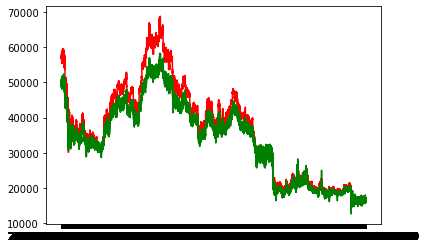

In [137]:
# Let's see how our model performs
X,y,X_lately = deal_coin_data(df_btc_re,the_mem_days,pre_days)   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
pre=best_model.predict(X_test)
BTC_time=df_btc_re.index[-len(y_test):]
plt.plot(BTC_time,y_test,color='red',label='price')
plt.plot(BTC_time,pre,color='green',label='price')
plt.show()

In [139]:
# Test a simple trading strategy -> if predict rise->buy!  if drop->short!

In [164]:
df_st = pd.DataFrame([y_test, list(pre)]).T
df_st.columns = ['real', 'pre']
df_st['pre_dif'] = df_st['pre'].diff()
df_st['pre_dif'][df_st['pre_dif']>=0] = 1
df_st['pre_dif'][df_st['pre_dif']<0] = -1
df_st['profit'] = (df_st['real'].diff().shift(-1) * df_st['pre_dif']).cumsum()

<AxesSubplot:title={'center':'Trading with LSTM'}>

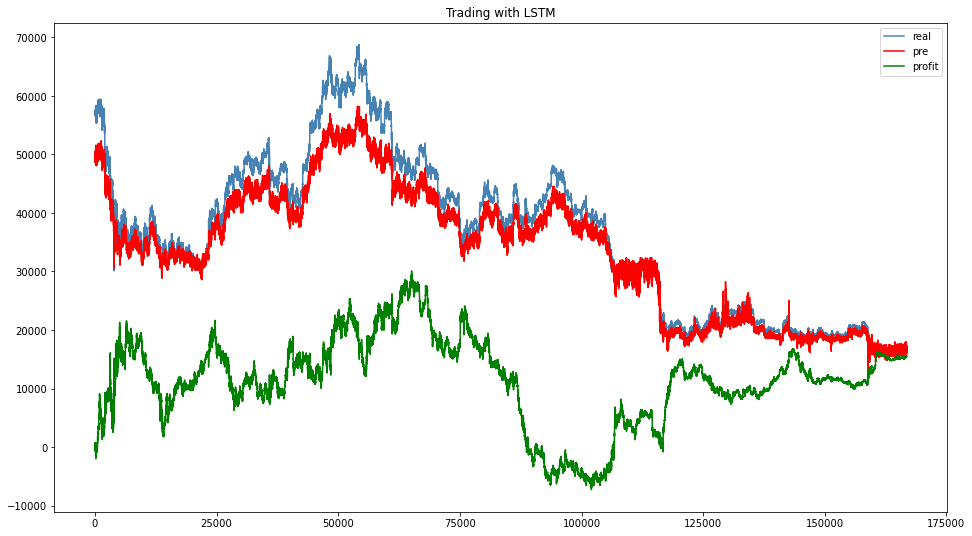

In [169]:
df_st['pre'] = df_st['pre'].astype('float')
df_st[['real', 'pre', 'profit']].plot(figsize=(16,9), color=['SteelBlue','Red', 'Green'],
                                          title='Trading with LSTM')

In [170]:
"We finally make something makes money...."

'We finally make something makes money....'